# **Modeling & Feature Engineering - Google Analytics Customer Revenue Prediction**

After cleaning and thorough exploration of the data set, we can move to find new features. And drop some unwanted columns that are not useful. Then we can proceed with model fitting.

[Import libraries and other setup](#section1)

[Load the cleaned data from previous work (ipynb)](#section2)

[Basic Features](#section3)
- [Identify and remove features](#section5)
- [Reduce levels for categorical variables](#section5)
- [Save the unique categories to be used for future predictions](#section5)
- [Encode categorical variables](#section5)

[Useful Functions](#section3)
- [Train Test split based on time](#section5)
- [Model Evaluation with results viz.](#section5)

[Baseline model](#section3)
- [Dumb model](#section5)
- [Decision Tree](#section5)
- [Random Forest](#section5)
- [XGBoost](#section5)
- [LightGBM](#section5)


[Feature Engineering](#section4)
- [Weekday or Weekend](#section6)
- [Holiday period](#section7)
- [Bin the days of Month](#section8)
- [Active hours](#section9)

[Modeling using engineered features](#section10)

[Future thoughts](#section11)


In [67]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, calendar
from collections import defaultdict
import plotly
import plotly.graph_objs as go
from sklearn import preprocessing
from sklearn import metrics

# ML models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb

# neural net
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Dropout
from keras import optimizers

# setup
plotly.offline.init_notebook_mode(connected=True)
#sns.set_style(style="whitegrid")
sns.set_style('ticks')
sns.set_palette('bright')

# display charts inline
%matplotlib inline

# to display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [68]:
import os

# adding to avoid the LightGBM related error, but is not the best solution
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Load previously cleaned train data

In [69]:
%%time
# load previously cleaned data
train_df = pd.read_csv('../data/extra_cols_train.csv',index_col=0, dtype={'fullVisitorId':'str'})

CPU times: user 6.64 s, sys: 694 ms, total: 7.34 s
Wall time: 7.4 s


### What does the data look like?

In [70]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,revenue,year,month,day,weekday,hour,day_of_year,local_hour
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,2,4,15,245,1
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,3,5,5,246,5
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,3,5,1,246,10
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,google + online,organic,Unknown,google,0.0,2016,9,3,5,5,246,5
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1,1,0,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,(not provided),organic,Unknown,google,0.0,2016,9,2,4,13,245,13


In [71]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899888 entries, 0 to 903652
Data columns (total 44 columns):
channelGrouping                                 899888 non-null object
date                                            899888 non-null int64
fullVisitorId                                   899888 non-null object
sessionId                                       899888 non-null object
visitId                                         899888 non-null int64
visitNumber                                     899888 non-null int64
visitStartTime                                  899888 non-null int64
device.browser                                  899888 non-null object
device.deviceCategory                           899888 non-null object
device.isMobile                                 899888 non-null bool
device.operatingSystem                          899888 non-null object
geoNetwork.city                                 899888 non-null object
geoNetwork.continent                       

### Basic Features

In [72]:
features_train_df = train_df.copy()

#### Identify and remove features

- ID variables are not useful, as they are unique to each mostly. Also, they don't make any business sense.
- Year variable can't be used because the data does not spread over many years.
- Continent data can be removed because we have finer granular Sub-continent.
- IsMobile will be a part of categorical variable deviceCategory. It is redundant and can be dropped.
- Date is used to derive month, day etc. date variables and can be dropped. 

In [73]:
# Let us remove columns that are not needed at all
cols_to_drop = []

# remove revenue because that was added just for better visualization purposes
cols_to_drop.append('revenue')

# id fields serve no purpose
cols_to_drop.append('fullVisitorId')
cols_to_drop.append('sessionId')
cols_to_drop.append('visitId')

# since we have data only for a year it is not useful
cols_to_drop.append('year')

# date is redundant because visitStartTime includes date
cols_to_drop.append('date')

# visitStartTime is broken into day, month etc. and exact time upto seconds doesn't make business sense
cols_to_drop.append('visitStartTime')

# continent is redundant becuase sub-continent is bit more granular but includes continent info
cols_to_drop.append('geoNetwork.continent')

# isMobile is redundant, device category already have that category
cols_to_drop.append('device.isMobile')

# features_train_df.drop(cols_to_drop, axis=1, inplace=True)
features_train_df.drop(cols_to_drop, axis=1, inplace=True)

In [74]:
checkpoint_1_df = features_train_df.copy()

In [75]:
#features_train_df = checkpoint_1_df.copy()

In [76]:
features_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899888 entries, 0 to 903652
Data columns (total 35 columns):
channelGrouping                                 899888 non-null object
visitNumber                                     899888 non-null int64
device.browser                                  899888 non-null object
device.deviceCategory                           899888 non-null object
device.operatingSystem                          899888 non-null object
geoNetwork.city                                 899888 non-null object
geoNetwork.country                              899888 non-null object
geoNetwork.metro                                899888 non-null object
geoNetwork.networkDomain                        899888 non-null object
geoNetwork.region                               899888 non-null object
geoNetwork.subContinent                         899888 non-null object
totals.bounces                                  899888 non-null int64
totals.hits                            

#### Reduce levels for categorical variables

In [77]:
# Handling the categorical data
# If some values of a categorical variable are less frequent than 5% than they all can be combined in one

In [78]:
all_cat_cols = list(features_train_df.select_dtypes(include='object').columns)
all_cat_cols

['channelGrouping',
 'device.browser',
 'device.deviceCategory',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.campaign',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source']

In [79]:
# reduces the levels for categorical variables
def reduce_category_levels(df, category_cols):
    ignored_cols = []
    mult_fact = 100/df.shape[0]
    for col in category_cols:
        unique_vals = df[col].nunique()
        print("\n"+col)
        print("number of unique values", unique_vals)
        
        val_percents = df[col].value_counts()*mult_fact
        dummy_val = ('dummy_'+str(col)).replace('.','_')
        print(dummy_val)
        
        values_to_be_replaced = []
        for val_percent in val_percents.iteritems():
            #print(val_percent[0], val_percent[1])
            if val_percent[1] < 1:
                values_to_be_replaced.append(val_percent[0])
        replace_idxs = df[df[col].isin(values_to_be_replaced)].index
        df.loc[replace_idxs,col] = dummy_val
        print("reduced number of unique values", df[col].nunique())
        print("remaining of unique values", df[col].unique())

    return ignored_cols

In [80]:
ignored_cols = reduce_category_levels(features_train_df, all_cat_cols)


channelGrouping
number of unique values 8
dummy_channelGrouping
reduced number of unique values 7
remaining of unique values ['Organic Search' 'Referral' 'Paid Search' 'Affiliates' 'Direct'
 'dummy_channelGrouping' 'Social']

device.browser
number of unique values 53
dummy_device_browser
reduced number of unique values 6
remaining of unique values ['Chrome' 'Firefox' 'dummy_device_browser' 'Internet Explorer' 'Safari'
 'Edge']

device.deviceCategory
number of unique values 3
dummy_device_deviceCategory
reduced number of unique values 3
remaining of unique values ['desktop' 'mobile' 'tablet']

device.operatingSystem
number of unique values 20
dummy_device_operatingSystem
reduced number of unique values 7
remaining of unique values ['Windows' 'Macintosh' 'Linux' 'Android' 'iOS' 'Chrome OS'
 'dummy_device_operatingSystem']

geoNetwork.city
number of unique values 649
dummy_geoNetwork_city
reduced number of unique values 9
remaining of unique values ['dummy_geoNetwork_city' 'not available

#### check out remaining category levels

In [81]:
unique_vals = [ (col, list(features_train_df[col].unique())) for col in all_cat_cols]

In [82]:
unique_vals = []
for col in all_cat_cols:
    uniques = list(features_train_df[col].unique())
    uniques.insert(0,col)
    unique_vals.append(uniques)

In [83]:
unique_vals

[['channelGrouping',
  'Organic Search',
  'Referral',
  'Paid Search',
  'Affiliates',
  'Direct',
  'dummy_channelGrouping',
  'Social'],
 ['device.browser',
  'Chrome',
  'Firefox',
  'dummy_device_browser',
  'Internet Explorer',
  'Safari',
  'Edge'],
 ['device.deviceCategory', 'desktop', 'mobile', 'tablet'],
 ['device.operatingSystem',
  'Windows',
  'Macintosh',
  'Linux',
  'Android',
  'iOS',
  'Chrome OS',
  'dummy_device_operatingSystem'],
 ['geoNetwork.city',
  'dummy_geoNetwork_city',
  'not available in demo dataset',
  '(not set)',
  'London',
  'Mountain View',
  'New York',
  'San Francisco',
  'Sunnyvale',
  'San Jose'],
 ['geoNetwork.country',
  'Turkey',
  'Australia',
  'Spain',
  'Indonesia',
  'United Kingdom',
  'Italy',
  'dummy_geoNetwork_country',
  'Netherlands',
  'India',
  'France',
  'Brazil',
  'Poland',
  'Germany',
  'Canada',
  'Thailand',
  'Taiwan',
  'Russia',
  'Philippines',
  'Mexico',
  'United States',
  'Japan',
  'Vietnam'],
 ['geoNetwork.m

#### Save the unique category levels to be used for future predictions

In [84]:
import json
data = {}

for col in all_cat_cols:
    uniques = list(features_train_df[col].unique())
    data[col] = uniques
    
json_data = json.dumps(data)

In [85]:
json_data

'{"channelGrouping": ["Organic Search", "Referral", "Paid Search", "Affiliates", "Direct", "dummy_channelGrouping", "Social"], "device.browser": ["Chrome", "Firefox", "dummy_device_browser", "Internet Explorer", "Safari", "Edge"], "device.deviceCategory": ["desktop", "mobile", "tablet"], "device.operatingSystem": ["Windows", "Macintosh", "Linux", "Android", "iOS", "Chrome OS", "dummy_device_operatingSystem"], "geoNetwork.city": ["dummy_geoNetwork_city", "not available in demo dataset", "(not set)", "London", "Mountain View", "New York", "San Francisco", "Sunnyvale", "San Jose"], "geoNetwork.country": ["Turkey", "Australia", "Spain", "Indonesia", "United Kingdom", "Italy", "dummy_geoNetwork_country", "Netherlands", "India", "France", "Brazil", "Poland", "Germany", "Canada", "Thailand", "Taiwan", "Russia", "Philippines", "Mexico", "United States", "Japan", "Vietnam"], "geoNetwork.metro": ["(not set)", "not available in demo dataset", "London", "San Francisco-Oakland-San Jose CA", "New Yo

In [86]:
type(data)

dict

In [87]:
with open('../data/unique_cat_values.json', 'w', encoding='utf-8') as f:
     json.dump(data, f)

In [88]:
features_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899888 entries, 0 to 903652
Data columns (total 35 columns):
channelGrouping                                 899888 non-null object
visitNumber                                     899888 non-null int64
device.browser                                  899888 non-null object
device.deviceCategory                           899888 non-null object
device.operatingSystem                          899888 non-null object
geoNetwork.city                                 899888 non-null object
geoNetwork.country                              899888 non-null object
geoNetwork.metro                                899888 non-null object
geoNetwork.networkDomain                        899888 non-null object
geoNetwork.region                               899888 non-null object
geoNetwork.subContinent                         899888 non-null object
totals.bounces                                  899888 non-null int64
totals.hits                            

In [89]:
features_train_df['geoNetwork.city'].unique()

array(['dummy_geoNetwork_city', 'not available in demo dataset',
       '(not set)', 'London', 'Mountain View', 'New York',
       'San Francisco', 'Sunnyvale', 'San Jose'], dtype=object)

In [90]:
checkpoint_2_df = features_train_df.copy()

#### Encode categorical variables

In [91]:
# Let us list category columns
cat_cols = features_train_df.select_dtypes(include=[object]).columns

In [92]:
cat_cols

Index(['channelGrouping', 'device.browser', 'device.deviceCategory',
       'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source'],
      dtype='object')

In [93]:
num_cols = features_train_df.select_dtypes(exclude=[object]).columns

In [94]:
num_cols

Index(['visitNumber', 'totals.bounces', 'totals.hits', 'totals.newVisits',
       'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page', 'trafficSource.campaignCode',
       'trafficSource.isTrueDirect', 'month', 'day', 'weekday', 'hour',
       'day_of_year', 'local_hour'],
      dtype='object')

In [95]:
# For our basic model we are not using date features
# also campaignCode doesn't exist in test data, so have to remove that

In [96]:
num_cols = set(num_cols)-set(['trafficSource.campaignCode','month', 'day', \
                              'weekday', 'hour', 'day_of_year', 'local_hour'])

In [97]:
num_cols

{'totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews',
 'totals.transactionRevenue',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.isTrueDirect',
 'visitNumber'}

In [98]:
all_cols = list(cat_cols.values)
all_cols.extend(list(num_cols))
X_basic = features_train_df[all_cols]

In [99]:
X_basic.shape

(899888, 28)

In [100]:
# encode category variables
X_basic = pd.get_dummies(X_basic, columns=cat_cols)

In [101]:
X_basic.shape

(899888, 139)

In [102]:
X_basic.head()

,totals.transactionRevenue,visitNumber,trafficSource.adwordsClickInfo.isVideoAd,totals.bounces,totals.pageviews,trafficSource.isTrueDirect,totals.newVisits,totals.hits,trafficSource.adwordsClickInfo.page,channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,channelGrouping_dummy_channelGrouping,device.browser_Chrome,device.browser_Edge,device.browser_Firefox,device.browser_Internet Explorer,device.browser_Safari,device.browser_dummy_device_browser,device.deviceCategory_desktop,device.deviceCategory_mobile,device.deviceCategory_tablet,device.operatingSystem_Android,device.operatingSystem_Chrome OS,device.operatingSystem_Linux,device.operatingSystem_Macintosh,device.operatingSystem_Windows,device.operatingSystem_dummy_device_operatingSystem,device.operatingSystem_iOS,geoNetwork.city_(not set),geoNetwork.city_London,geoNetwork.city_Mountain View,geoNetwork.city_New York,geoNetwork.city_San Francisco,geoNetwork.city_San Jose,geoNetwork.city_Sunnyvale,geoNetwork.city_dummy_geoNetwork_city,geoNetwork.city_not available in demo dataset,geoNetwork.country_Australia,geoNetwork.country_Brazil,geoNetwork.country_Canada,geoNetwork.country_France,geoNetwork.country_Germany,geoNetwork.country_India,geoNetwork.country_Indonesia,geoNetwork.country_Italy,geoNetwork.country_Japan,geoNetwork.country_Mexico,geoNetwork.country_Netherlands,geoNetwork.country_Philippines,geoNetwork.country_Poland,geoNetwork.country_Russia,geoNetwork.country_Spain,geoNetwork.country_Taiwan,geoNetwork.country_Thailand,geoNetwork.country_Turkey,geoNetwork.country_United Kingdom,geoNetwork.country_United States,geoNetwork.country_Vietnam,geoNetwork.country_dummy_geoNetwork_country,geoNetwork.metro_(not set),geoNetwork.metro_London,geoNetwork.metro_Los Angeles CA,geoNetwork.metro_New York NY,geoNetwork.metro_San Francisco-Oakland-San Jose CA,geoNetwork.metro_dummy_geoNetwork_metro,geoNetwork.metro_not available in demo dataset,geoNetwork.networkDomain_(not set),geoNetwork.networkDomain_comcast.net,geoNetwork.networkDomain_comcastbusiness.net,geoNetwork.networkDomain_dummy_geoNetwork_networkDomain,geoNetwork.networkDomain_rr.com,geoNetwork.networkDomain_ttnet.com.tr,geoNetwork.networkDomain_unknown.unknown,geoNetwork.networkDomain_verizon.net,geoNetwork.region_(not set),geoNetwork.region_California,geoNetwork.region_England,geoNetwork.region_New York,geoNetwork.region_dummy_geoNetwork_region,geoNetwork.region_not available in demo dataset,geoNetwork.subContinent_Australasia,geoNetwork.subContinent_Central America,geoNetwork.subContinent_Eastern Asia,geoNetwork.subContinent_Eastern Europe,geoNetwork.subContinent_Northern America,geoNetwork.subContinent_Northern Europe,geoNetwork.subContinent_South America,geoNetwork.subContinent_Southeast Asia,geoNetwork.subContinent_Southern Asia,geoNetwork.subContinent_Southern Europe,geoNetwork.subContinent_Western Asia,geoNetwork.subContinent_Western Europe,geoNetwork.subContinent_dummy_geoNetwork_subContinent,trafficSource.adContent_Others,trafficSource.adContent_dummy_trafficSource_adContent,trafficSource.adwordsClickInfo.adNetworkType_Google Search,trafficSource.adwordsClickInfo.adNetworkType_Unknown,trafficSource.adwordsClickInfo.adNetworkType_dummy_trafficSource_adwordsClickInfo_adNetworkType,trafficSource.adwordsClickInfo.gclId_Unknown,trafficSource.adwordsClickInfo.gclId_dummy_trafficSource_adwordsClickInfo_gclId,trafficSource.adwordsClickInfo.slot_Top,trafficSource.adwordsClickInfo.slot_Unknown,trafficSource.adwordsClickInfo.slot_dummy_trafficSource_adwordsClickInfo_slot,trafficSource.campaign_(not set),trafficSource.campaign_AW - Dynamic Search Ads Whole Site,trafficSource.campaign_Data Share Promo,trafficSource.campaign_dummy_trafficSource_campaign,trafficSource.keyword_(not provided),trafficSource.keyword_6qEhsCssdK0z36ri,trafficSource.keyword_Unknown,trafficSource.keyword_dummy_trafficSource_keyword,trafficSource.medium_(n

### Useful Functions

Reusable functions to apply DRY principle.

#### Train Test split based on time

The function also takes the log of target as per Kaggle project requirements

In [140]:
# get train test based on time split
def get_train_test(X, train_df):
    #train_df['date'].min(), train_df['date'].max()
    train = train_df[train_df['date']<20170601].index
    test = train_df[train_df['date']>=20170601].index
    
    X_train = X.loc[train]
    X_test = X.loc[test]
    
    y_train = X_train['totals.transactionRevenue']
    y_test = X_test['totals.transactionRevenue']
    
    y_train = np.log1p(y_train.values)
    y_test = np.log1p(y_test.values)
    
    X_train.drop('totals.transactionRevenue', axis=1, inplace=True)
    X_test.drop('totals.transactionRevenue', axis=1, inplace=True)

    return X_train, X_test, y_train, y_test    

#### Model evaluation

- Makes negative predictions equal to 0
- Takes exponential of predicted revenues
- Group by visitorId and take sum of actual and predicted revenues
- Take the log of actual and predicted revenues per visitorId
- Calculate the metric RMSE - Root Mean Squared Error 
- Plot actual vs predicted
- Plot residuals against the actual revenues per visitorId

In [104]:
# evaluate the model
def evaluate_model(predictions, actuals, X_test, train_df):
    # revenue can't be less than zero
    predictions[predictions<0] = 0
    
    results_df = train_df[['fullVisitorId','totals.transactionRevenue']]
    results_df = results_df.loc[X_test.index]
    #print("Index for test set: \n", results_df.index)
    
    results_df['predicted_revenue'] = [np.expm1(rev) for rev in predictions]
    print("\nShape: ", results_df.shape)
    print("\nTotals vs predcited: \n",results_df.head())
    
    # revenues have to be grouped by visitors
    results_df = results_df.groupby("fullVisitorId")["totals.transactionRevenue", \
                                                     "predicted_revenue"].sum().reset_index()
    
    actuals_per_visitor = np.log1p(results_df["totals.transactionRevenue"].values)
    predictions_per_visitor = np.log1p(results_df["predicted_revenue"].values)
    
    rmse = np.sqrt(metrics.mean_squared_error(actuals_per_visitor, predictions_per_visitor))
    print("\nrmse: ", rmse)
    
    # plot actual vs predicted
    plt.title("Actual vs Predicted revenues")
    plt.xlabel("Actual revenue (log)")
    plt.ylabel("Predicted revenue (log)")
    plt.scatter(actuals_per_visitor, predictions_per_visitor)
    plt.show()
    
    # trial plot - this shows good plot but this log instead of log1, investigate further what is correct
#     plt.scatter(results_df['totals.transactionRevenue'].apply(np.log), results_df['predicted_revenue'].apply(np.log))
#     plt.show()
    # trial plot ends
    
    print("actuals: min = {}, mean = {}, max = {}".format(\
                    actuals_per_visitor.min(), actuals_per_visitor.mean(), actuals_per_visitor.max()))
    print("pedictions: min = {}, mean = {}, max = {}".format(\
                    predictions_per_visitor.min(), predictions_per_visitor.mean(), predictions_per_visitor.max()))
    
    plt.title("Residual Plot")
    plt.xlabel("Actual transaction revenue")
    plt.ylabel("Residuals (actuals - predictions)")
    plt.scatter(x=actuals_per_visitor, y=(actuals_per_visitor-predictions_per_visitor))
    plt.show()
    
    return (rmse, actuals_per_visitor, predictions_per_visitor)

In [141]:
X_basic_train, X_basic_test, y_basic_train, y_basic_test = get_train_test(X_basic, train_df)

In [142]:
X_basic_train.shape, X_basic_test.shape, y_basic_train.shape, y_basic_test.shape

((762857, 138), (137031, 138), (762857,), (137031,))

### Baseline Model

Before doing any kind of machine learning, let us do a very simple human level prediction. That will give us the worst case to start with.

Let us evaluate out dumb model, that predicts all revenues per visitor to be zero.

In [107]:
# variable to save all model results
results_dict = defaultdict()

In [108]:
# test out if we predict 0 revenue ....just for testing purposes
# copy the shape of test target
dumb_predictions = pd.Series(y_basic_test)
print(dumb_predictions.shape)
dumb_predictions[:] = 0
dumb_predictions.describe()

(137031,)


count    137031.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64


Shape:  (137031, 3)

Totals vs predcited: 
             fullVisitorId  totals.transactionRevenue  predicted_revenue
4822  6136444193474843946                        0.0                0.0
4823  9499266297099251015                        0.0                0.0
4824   965275377736384905                        0.0                0.0
4825  4609130972135924274                        0.0                0.0
4826  7154533339220730030                        0.0                0.0

rmse:  2.2907636856618057


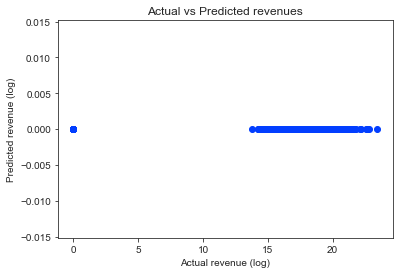

actuals: min = 0.0, mean = 0.2943813702846033, max = 23.442593540690858
pedictions: min = 0.0, mean = 0.0, max = 0.0


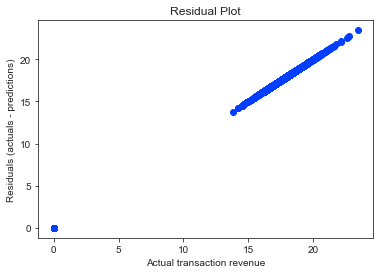

In [109]:
rmse,_,_ = evaluate_model(dumb_predictions, y_basic_test, X_basic_test, train_df)
results_dict["Dumb Model"] = (rmse,"Dumb baseline results model that predicts all 0s")

In [110]:
results_dict

defaultdict(None,
            {'Dumb Model': (2.2907636856618057,
              'Dumb baseline results model that predicts all 0s')})

#### First baseline model using Decision Tree

In [111]:
# basic model
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X=X_basic_train,y=y_basic_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [112]:
pred_val_basic = dt.predict(X=X_basic_test)


Shape:  (137031, 3)

Totals vs predcited: 
             fullVisitorId  totals.transactionRevenue  predicted_revenue
4822  6136444193474843946                        0.0                0.0
4823  9499266297099251015                        0.0                0.0
4824   965275377736384905                        0.0                0.0
4825  4609130972135924274                        0.0                0.0
4826  7154533339220730030                        0.0                0.0

rmse:  2.2987679322716525


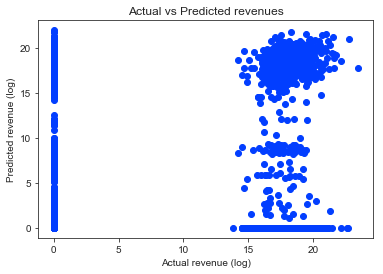

actuals: min = 0.0, mean = 0.2943813702846033, max = 23.442593540690858
pedictions: min = 0.0, mean = 0.24444946919052013, max = 21.94374171366645


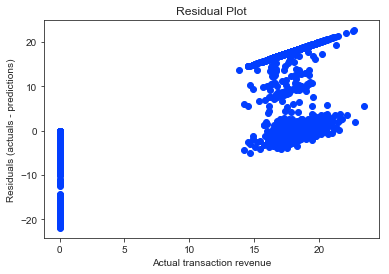

In [113]:
rmse,_,_ = evaluate_model(pred_val_basic, y_basic_test, X_basic_test, train_df)
results_dict["Decision Tree"] = (rmse, "Baseline Decision Tree")

In [114]:
for row in results_dict:
    print(row, results_dict[row])

Dumb Model (2.2907636856618057, 'Dumb baseline results model that predicts all 0s')
Decision Tree (2.2987679322716525, 'Baseline Decision Tree')


#### Random Forest

In [115]:
rf = RandomForestRegressor(n_estimators=1000)

In [116]:
rf.fit(X=X_basic_train[0:10000],y=y_basic_train[0:10000])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


Shape:  (137031, 3)

Totals vs predcited: 
             fullVisitorId  totals.transactionRevenue  predicted_revenue
4822  6136444193474843946                        0.0                0.0
4823  9499266297099251015                        0.0                0.0
4824   965275377736384905                        0.0                0.0
4825  4609130972135924274                        0.0                0.0
4826  7154533339220730030                        0.0                0.0

rmse:  1.8699230646199105


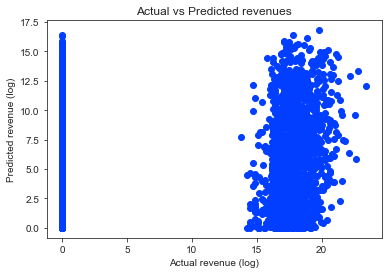

actuals: min = 0.0, mean = 0.2943813702846033, max = 23.442593540690858
pedictions: min = 0.0, mean = 0.21023250816075534, max = 16.792636807756807


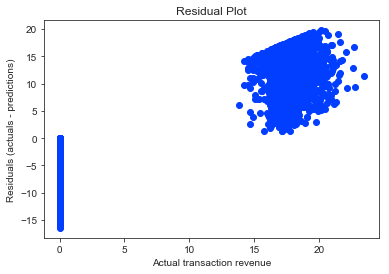

In [117]:
rmse,_,_ = evaluate_model(rf.predict(X_basic_test), y_basic_test, X_basic_test, train_df)
results_dict["Random Forest"] = (rmse, "Random Forest with only 10K training rows")

In [118]:
for row in results_dict:
    print(row, results_dict[row])

Dumb Model (2.2907636856618057, 'Dumb baseline results model that predicts all 0s')
Decision Tree (2.2987679322716525, 'Baseline Decision Tree')
Random Forest (1.8699230646199105, 'Random Forest with only 10K training rows')


#### XGBoost

In [119]:
xgb_reg = xgb.XGBRegressor(
         learning_rate =0.1,
         n_estimators=1000,
         max_depth=5,
         min_child_weight=1,
         gamma=0,
         subsample=0.8,
         colsample_bytree=0.8,
         objective= 'reg:linear',
         nthread=4,
         scale_pos_weight=1,
         seed=19)

In [120]:
xgb_reg.fit(X_basic_train[0:10000],y_basic_train[0:10000],eval_metric='rmse')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=19, silent=True,
       subsample=0.8)


Shape:  (137031, 3)

Totals vs predcited: 
             fullVisitorId  totals.transactionRevenue  predicted_revenue
4822  6136444193474843946                        0.0           0.000035
4823  9499266297099251015                        0.0           0.001967
4824   965275377736384905                        0.0           0.009621
4825  4609130972135924274                        0.0           0.000814
4826  7154533339220730030                        0.0           0.000000

rmse:  1.956678625077371


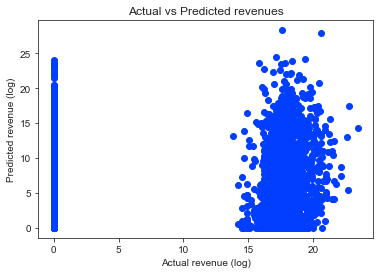

actuals: min = 0.0, mean = 0.2943813702846033, max = 23.442593540690858
pedictions: min = 0.0, mean = 0.2558095887508392, max = 28.300594353033667


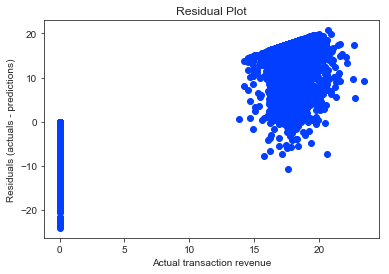

In [121]:
rmse,_,_ = evaluate_model(xgb_reg.predict(X_basic_test), y_basic_test, X_basic_test, train_df)
results_dict["XGB"] = (rmse, "XGBoost Regressor with only 10K training rows. Params are (learning_rate=0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='reg:linear', nthread=4, scale_pos_weight=1, seed=19)")

#### LightGBM

In [143]:
# custom function to run light gbm model
# might try with a different validation set, not doing because we have extra test set file for submission
def run_lgb(train_X, train_y, val_X, val_y):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 10000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return model, pred_val_y

In [145]:
# Training the model #
lgb_model, pred_val_lgb = run_lgb(X_basic_train, y_basic_train, X_basic_test, y_basic_test)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.72064
[200]	valid_0's rmse: 1.71695
[300]	valid_0's rmse: 1.7168
Early stopping, best iteration is:
[277]	valid_0's rmse: 1.71635



Shape:  (137031, 3)

Totals vs predcited: 
             fullVisitorId  totals.transactionRevenue  predicted_revenue
4822  6136444193474843946                        0.0            0.00000
4823  9499266297099251015                        0.0            0.00000
4824   965275377736384905                        0.0            0.00000
4825  4609130972135924274                        0.0            0.00225
4826  7154533339220730030                        0.0            0.00132

rmse:  1.756594482896764


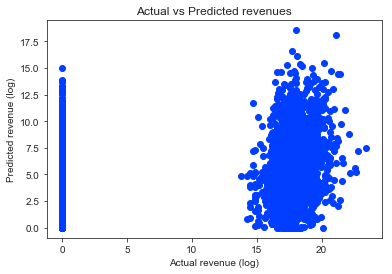

actuals: min = 0.0, mean = 0.2943813702846033, max = 23.442593540690858
pedictions: min = 0.0, mean = 0.21952212350795403, max = 18.523190863921034


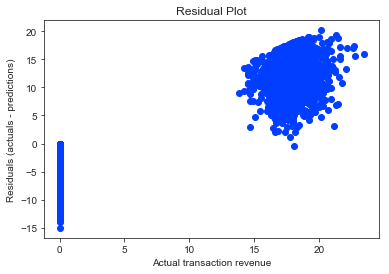

In [146]:
rmse, lgb_acts, lgb_preds = evaluate_model(pred_val_lgb, y_basic_test, X_basic_test, train_df)
results_dict["LightGBM"] = (rmse, 'LightGBM with basic features and default params')

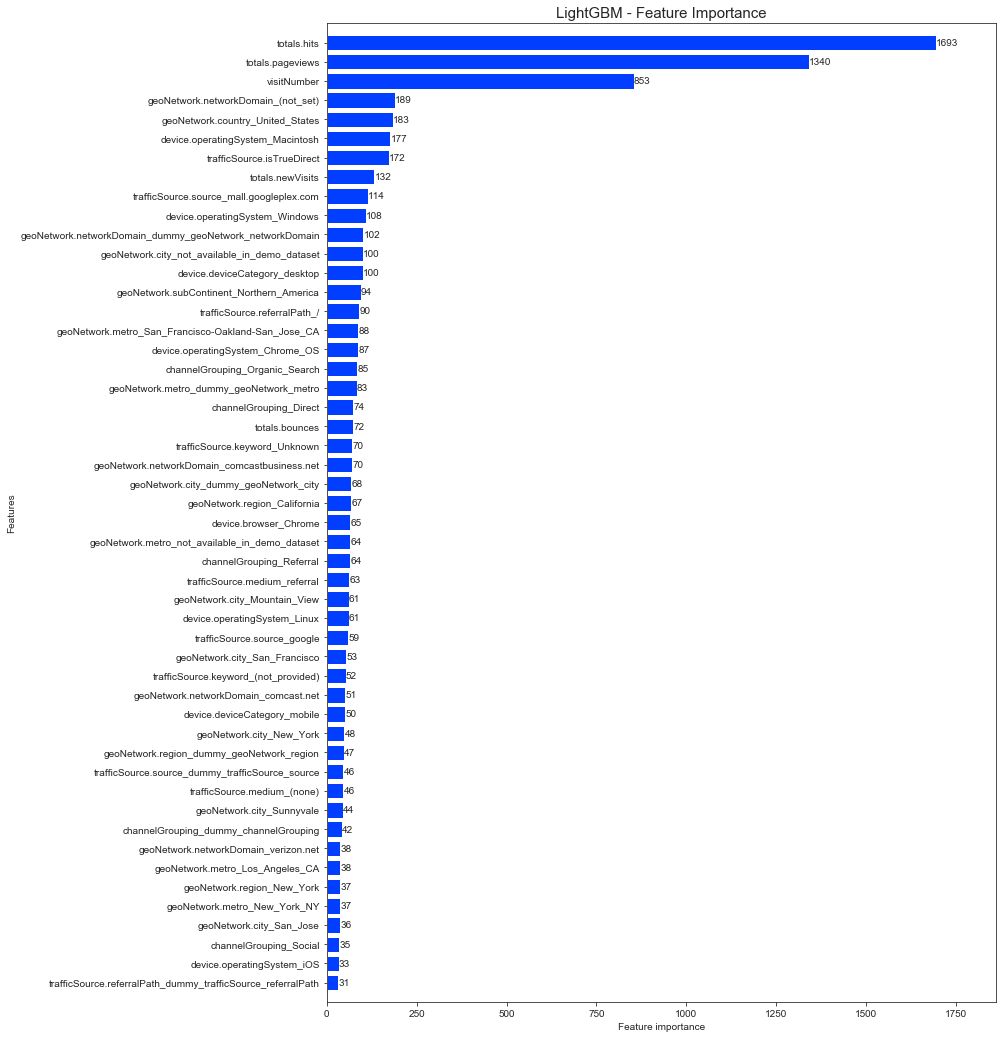

In [147]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(lgb_model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

### Feature Engineering

Based on the EDA done till now and gaining some insights and intuition about the data, we can now derive some new features. After testing the machine learning models, we can keep them if useful. We have already added some features at the time of EDA.

#### Previously added new features

- **hour** - Extracted this feature from visitStartTime. The login hour might serve some business meaning.
- **local_hour** - This is hour but calculated keeping in mind the location of the visitor. This is more meaningful than just UTC hour.
- **day** - We saw some patterns within the month. This feature can capture that pattern.
- **day_of_year** - Again based on EDA there are variations in the data for all the days of the year.
- **weekday** - Captures the weekly patterns of the data.
- **month** - Captures the monthly pattern of the data.

#### New feature: quarter

The whole year can be divided into quarters. This feature might capture holiday season or financial year start etc.

In [148]:
# quarter
features_train_df['quarter'] = features_train_df['month'].apply(lambda x: 'quarter'+str(np.mod(x,4)))

#### New feature: week_day_end

As seen from EDA there are more logins or weekends but less sales. It might indicate that people have leisure time and they browse and not necessarily interested in buying.

In [149]:
features_train_df['week_day_end'] = features_train_df['weekday'].apply(lambda x: 1 if x<5 else 0)

#### New feature: holidays

At the end of the year there is first rise in the number of the logins and then some days later there is rise in revenue transactions. We can define that period as holiday period.

In [150]:
features_train_df['holidays'] = 0
features_train_df.loc[(train_df['day_of_year'] > 330),'holidays'] = 1

#### New feature: month_period

Whole month can be divided into start, mid and end. Start might indicate the arrival of salaries etc. Month end might be related to more expenditure.

In [151]:
# month start, mid, end
features_train_df['month_period'] = features_train_df['day'].apply(lambda x: 'start' if x<6 else 'mid' if x>25 else 'end')

#### New feature: active_hours

As seen during the EDA that morning hours are generally low on revenue transactions. This makes sense because people are generally busy getting ready for the work day ahead.

In [152]:
features_train_df['active_hours'] = 0
features_train_df.loc[(~train_df['local_hour'].isin([7,8,9,10,11,12])),'active_hours'] = 1

In [153]:
# Let us list category columns
cat_cols_2 = features_train_df.select_dtypes(include=[object]).columns

In [154]:
cat_cols_2

Index(['channelGrouping', 'device.browser', 'device.deviceCategory',
       'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source', 'quarter',
       'month_period'],
      dtype='object')

In [155]:
num_cols_2 = features_train_df.select_dtypes(exclude=[object]).columns

In [156]:
num_cols_2

Index(['visitNumber', 'totals.bounces', 'totals.hits', 'totals.newVisits',
       'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page', 'trafficSource.campaignCode',
       'trafficSource.isTrueDirect', 'month', 'day', 'weekday', 'hour',
       'day_of_year', 'local_hour', 'week_day_end', 'holidays',
       'active_hours'],
      dtype='object')

In [157]:
# We can now discard some old date features, from which we have extracted new features
# also campaignCode doesn't exist in test data, so have to remove that

In [158]:
num_cols_2 = set(num_cols_2)-set(['trafficSource.campaignCode','month', 'day', \
                              'weekday', 'hour', 'day_of_year', 'local_hour'])

In [159]:
num_cols_2

{'active_hours',
 'holidays',
 'totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews',
 'totals.transactionRevenue',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.isTrueDirect',
 'visitNumber',
 'week_day_end'}

In [160]:
all_cols_2 = list(cat_cols_2.values)
all_cols_2.extend(list(num_cols_2))
X_new = features_train_df[all_cols_2]

In [161]:
X_new.shape

(899888, 33)

In [162]:
# encode category variables
X_new = pd.get_dummies(X_new, columns=cat_cols_2)

In [163]:
X_new.shape

(899888, 149)

In [164]:
X_new.head()

,totals.transactionRevenue,visitNumber,trafficSource.adwordsClickInfo.isVideoAd,totals.bounces,totals.pageviews,trafficSource.isTrueDirect,totals.newVisits,totals.hits,active_hours,trafficSource.adwordsClickInfo.page,holidays,week_day_end,channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,channelGrouping_dummy_channelGrouping,device.browser_Chrome,device.browser_Edge,device.browser_Firefox,device.browser_Internet Explorer,device.browser_Safari,device.browser_dummy_device_browser,device.deviceCategory_desktop,device.deviceCategory_mobile,device.deviceCategory_tablet,device.operatingSystem_Android,device.operatingSystem_Chrome OS,device.operatingSystem_Linux,device.operatingSystem_Macintosh,device.operatingSystem_Windows,device.operatingSystem_dummy_device_operatingSystem,device.operatingSystem_iOS,geoNetwork.city_(not set),geoNetwork.city_London,geoNetwork.city_Mountain View,geoNetwork.city_New York,geoNetwork.city_San Francisco,geoNetwork.city_San Jose,geoNetwork.city_Sunnyvale,geoNetwork.city_dummy_geoNetwork_city,geoNetwork.city_not available in demo dataset,geoNetwork.country_Australia,geoNetwork.country_Brazil,geoNetwork.country_Canada,geoNetwork.country_France,geoNetwork.country_Germany,geoNetwork.country_India,geoNetwork.country_Indonesia,geoNetwork.country_Italy,geoNetwork.country_Japan,geoNetwork.country_Mexico,geoNetwork.country_Netherlands,geoNetwork.country_Philippines,geoNetwork.country_Poland,geoNetwork.country_Russia,geoNetwork.country_Spain,geoNetwork.country_Taiwan,geoNetwork.country_Thailand,geoNetwork.country_Turkey,geoNetwork.country_United Kingdom,geoNetwork.country_United States,geoNetwork.country_Vietnam,geoNetwork.country_dummy_geoNetwork_country,geoNetwork.metro_(not set),geoNetwork.metro_London,geoNetwork.metro_Los Angeles CA,geoNetwork.metro_New York NY,geoNetwork.metro_San Francisco-Oakland-San Jose CA,geoNetwork.metro_dummy_geoNetwork_metro,geoNetwork.metro_not available in demo dataset,geoNetwork.networkDomain_(not set),geoNetwork.networkDomain_comcast.net,geoNetwork.networkDomain_comcastbusiness.net,geoNetwork.networkDomain_dummy_geoNetwork_networkDomain,geoNetwork.networkDomain_rr.com,geoNetwork.networkDomain_ttnet.com.tr,geoNetwork.networkDomain_unknown.unknown,geoNetwork.networkDomain_verizon.net,geoNetwork.region_(not set),geoNetwork.region_California,geoNetwork.region_England,geoNetwork.region_New York,geoNetwork.region_dummy_geoNetwork_region,geoNetwork.region_not available in demo dataset,geoNetwork.subContinent_Australasia,geoNetwork.subContinent_Central America,geoNetwork.subContinent_Eastern Asia,geoNetwork.subContinent_Eastern Europe,geoNetwork.subContinent_Northern America,geoNetwork.subContinent_Northern Europe,geoNetwork.subContinent_South America,geoNetwork.subContinent_Southeast Asia,geoNetwork.subContinent_Southern Asia,geoNetwork.subContinent_Southern Europe,geoNetwork.subContinent_Western Asia,geoNetwork.subContinent_Western Europe,geoNetwork.subContinent_dummy_geoNetwork_subContinent,trafficSource.adContent_Others,trafficSource.adContent_dummy_trafficSource_adContent,trafficSource.adwordsClickInfo.adNetworkType_Google Search,trafficSource.adwordsClickInfo.adNetworkType_Unknown,trafficSource.adwordsClickInfo.adNetworkType_dummy_trafficSource_adwordsClickInfo_adNetworkType,trafficSource.adwordsClickInfo.gclId_Unknown,trafficSource.adwordsClickInfo.gclId_dummy_trafficSource_adwordsClickInfo_gclId,trafficSource.adwordsClickInfo.slot_Top,trafficSource.adwordsClickInfo.slot_Unknown,trafficSource.adwordsClickInfo.slot_dummy_trafficSource_adwordsClickInfo_slot,trafficSource.campaign_(not set),trafficSource.campaign_AW - Dynamic Search Ads Whole Site,trafficSource.campaign_Data Share Promo,trafficSource.campaign_dummy_trafficSource_campaign,trafficSource.keyword_(not provided),trafficSource.keyword_6qEhsCssdK0z36ri,trafficSource.keyword_Unknown,trafficSource.keyword_dummy_trafficSou

In [165]:
X_new_train, X_new_test, y_new_train, y_new_test = get_train_test(X_new, train_df)

In [166]:
X_new_train.shape, X_new_test.shape, y_new_train.shape, y_new_test.shape

((762857, 148), (137031, 148), (762857,), (137031,))

#### Decision Tree Regressor

In [167]:
# new model with new features
dt2 = DecisionTreeRegressor(random_state=42)
dt2.fit(X=X_new_train,y=y_new_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [168]:
pred_val_new = dt2.predict(X=X_new_test)


Shape:  (137031, 3)

Totals vs predcited: 
             fullVisitorId  totals.transactionRevenue  predicted_revenue
4822  6136444193474843946                        0.0                0.0
4823  9499266297099251015                        0.0                0.0
4824   965275377736384905                        0.0                0.0
4825  4609130972135924274                        0.0                0.0
4826  7154533339220730030                        0.0                0.0

rmse:  2.351276559970123


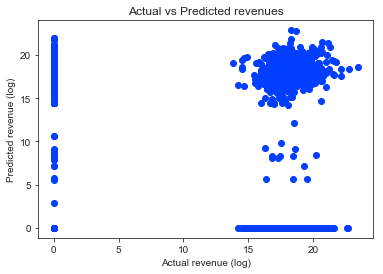

actuals: min = 0.0, mean = 0.2943813702846033, max = 23.442593540690858
pedictions: min = 0.0, mean = 0.25065081801735045, max = 22.859093619535454


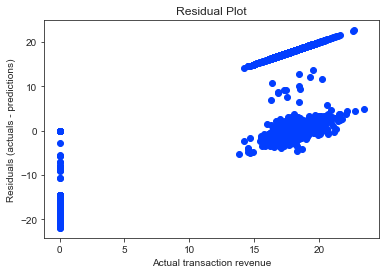

In [169]:
rmse,_,_ = evaluate_model(pred_val_new, y_new_test, X_new_test, train_df)
results_dict["Decistion Tree"] = (rmse, 'Decision Tree with new features')

In [170]:
# There is no improvement about new features in Decision Tree

In [171]:
# random forest needs lot of in memory, hence not being persued further with new features
# similarly XGB is taking up lot of memory

#### Light GBM

In [172]:
# Training the model #
lgb_model_2, pred_val_lgb_2 = run_lgb(X_new_train, y_new_train, X_new_test, y_new_test)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.71823
[200]	valid_0's rmse: 1.71688
Early stopping, best iteration is:
[157]	valid_0's rmse: 1.71627



Shape:  (137031, 3)

Totals vs predcited: 
             fullVisitorId  totals.transactionRevenue  predicted_revenue
4822  6136444193474843946                        0.0                0.0
4823  9499266297099251015                        0.0                0.0
4824   965275377736384905                        0.0                0.0
4825  4609130972135924274                        0.0                0.0
4826  7154533339220730030                        0.0                0.0

rmse:  1.7603621323849943


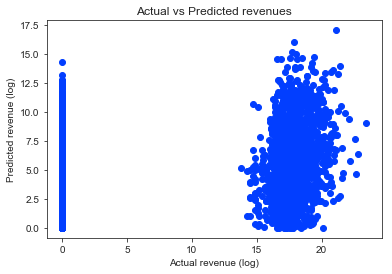

actuals: min = 0.0, mean = 0.2943813702846033, max = 23.442593540690858
pedictions: min = 0.0, mean = 0.21605805163620223, max = 16.996261560552494


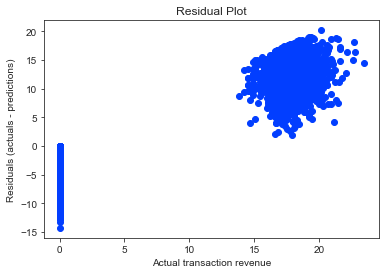

In [173]:
rmse,_,_ = evaluate_model(pred_val_lgb_2, y_new_test, X_new_test, train_df)
results_dict["LightGBM2"] = (rmse, 'Light GBM with new features')

In [566]:
# No improvement in LGBM either

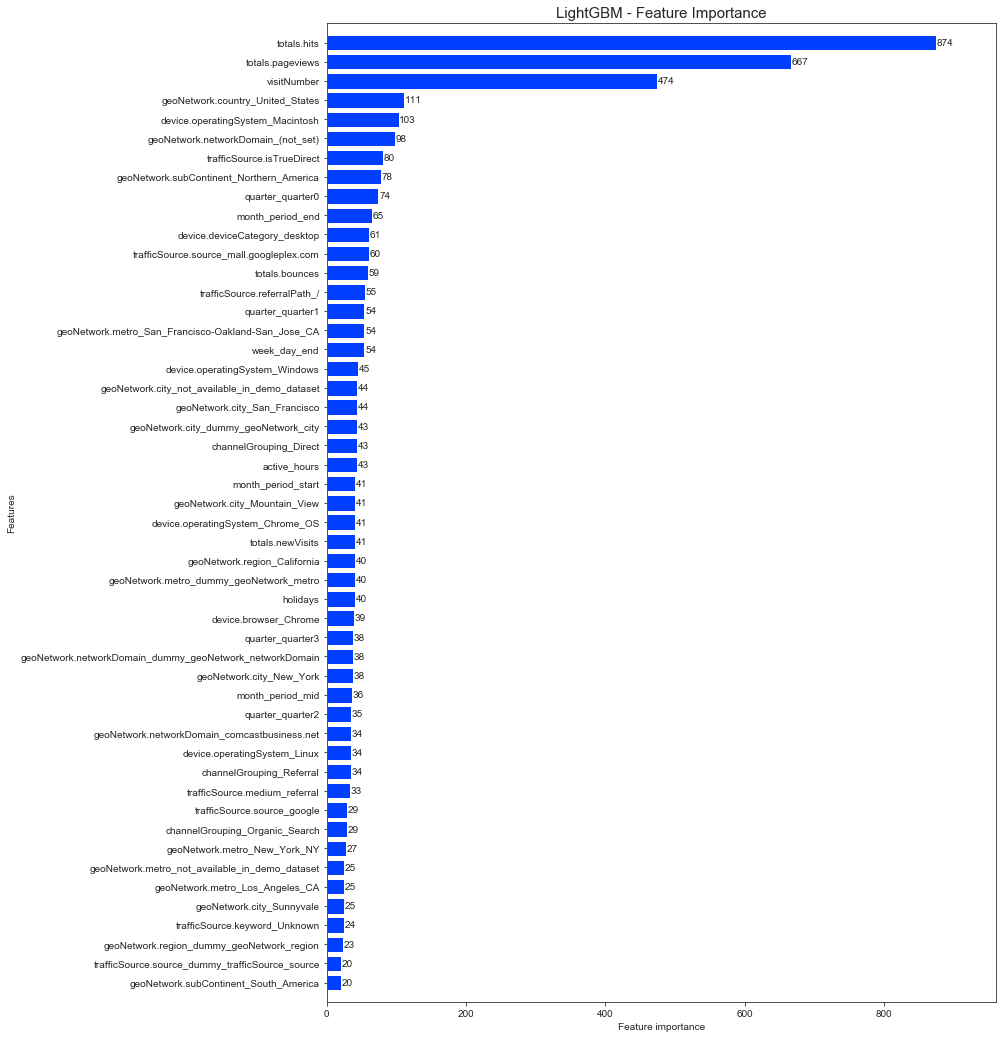

In [174]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(lgb_model_2, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

#### Neural Nets

In [175]:
numeric_cols = ['visitNumber', 'totals.hits', 'totals.pageviews', 'trafficSource.adwordsClickInfo.page']

In [176]:
# Normalize using Min-Max scaling
scaler = preprocessing.MinMaxScaler()
X_new_train[numeric_cols] = scaler.fit_transform(X_new_train[numeric_cols])
X_new_test[numeric_cols] = scaler.transform(X_new_test[numeric_cols])

In [177]:
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001

model = Sequential()
model.add(Dense(100, kernel_initializer='glorot_normal', activation='relu', input_dim=X_new_train.shape[1]))
model.add(Dense(65, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1))

adam = optimizers.adam(lr=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam)

In [178]:
print('Dataset size: %s' % X_new_train.shape[0])
print('Epochs: %s' % EPOCHS)
print('Learning rate: %s' % LEARNING_RATE)
print('Batch size: %s' % BATCH_SIZE)
print('Input dimension: %s' % X_new_train.shape[1])
print('Features used: %s' % X_new_train.columns.values)

Dataset size: 762857
Epochs: 10
Learning rate: 0.001
Batch size: 64
Input dimension: 148
Features used: ['visitNumber' 'trafficSource.adwordsClickInfo.isVideoAd' 'totals.bounces'
 'totals.pageviews' 'trafficSource.isTrueDirect' 'totals.newVisits'
 'totals.hits' 'active_hours' 'trafficSource.adwordsClickInfo.page'
 'holidays' 'week_day_end' 'channelGrouping_Affiliates'
 'channelGrouping_Direct' 'channelGrouping_Organic Search'
 'channelGrouping_Paid Search' 'channelGrouping_Referral'
 'channelGrouping_Social' 'channelGrouping_dummy_channelGrouping'
 'device.browser_Chrome' 'device.browser_Edge' 'device.browser_Firefox'
 'device.browser_Internet Explorer' 'device.browser_Safari'
 'device.browser_dummy_device_browser' 'device.deviceCategory_desktop'
 'device.deviceCategory_mobile' 'device.deviceCategory_tablet'
 'device.operatingSystem_Android' 'device.operatingSystem_Chrome OS'
 'device.operatingSystem_Linux' 'device.operatingSystem_Macintosh'
 'device.operatingSystem_Windows'
 'device.o

In [179]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               14900     
_________________________________________________________________
dense_2 (Dense)              (None, 65)                6565      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 66        
Total params: 21,531
Trainable params: 21,531
Non-trainable params: 0
_________________________________________________________________


In [180]:
%%time
history = model.fit(x=X_new_train.values, y=y_new_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(X_new_test.values, y_new_test))

Train on 762857 samples, validate on 137031 samples
Epoch 1/10
762857/762857 [==============================] - 22s 29us/step - loss: 3.1421 - val_loss: 3.2976
Epoch 2/10
762857/762857 [==============================] - 22s 29us/step - loss: 2.9006 - val_loss: 3.3016
Epoch 3/10
762857/762857 [==============================] - 22s 28us/step - loss: 2.8718 - val_loss: 3.1547
Epoch 4/10
762857/762857 [==============================] - 22s 28us/step - loss: 2.8475 - val_loss: 3.1759
Epoch 5/10
762857/762857 [==============================] - 22s 29us/step - loss: 2.8316 - val_loss: 3.2209
Epoch 6/10
762857/762857 [==============================] - 22s 28us/step - loss: 2.8146 - val_loss: 3.1894
Epoch 7/10
762857/762857 [==============================] - 22s 28us/step - loss: 2.7982 - val_loss: 3.1525
Epoch 8/10
762857/762857 [==============================] - 22s 29us/step - loss: 2.7845 - val_loss: 3.1851
Epoch 9/10
762857/762857 [==============================] - 22s 29us/step - loss: 2.

In [181]:
pred_val_nn = model.predict(X_new_test)

In [182]:
pred_val_nn = pred_val_nn.flatten()


Shape:  (137031, 3)

Totals vs predcited: 
             fullVisitorId  totals.transactionRevenue  predicted_revenue
4822  6136444193474843946                        0.0            0.00000
4823  9499266297099251015                        0.0            0.00046
4824   965275377736384905                        0.0            0.00000
4825  4609130972135924274                        0.0            0.00000
4826  7154533339220730030                        0.0            0.00000

rmse:  1.859541111030134


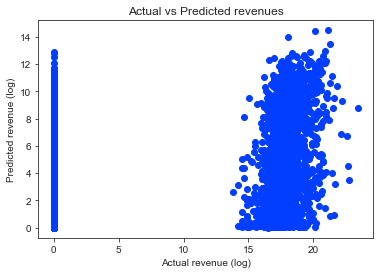

actuals: min = 0.0, mean = 0.2943813702846033, max = 23.442593540690858
pedictions: min = 0.0, mean = 0.1751656292849615, max = 14.458163528578579


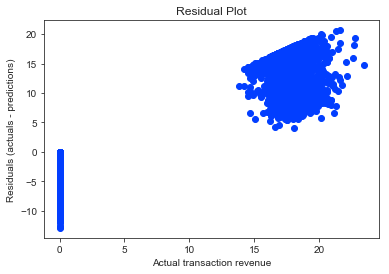

In [183]:
rmse, nn_acts, nn_preds = evaluate_model(pred_val_nn, y_new_test, X_new_test, train_df)
results_dict['Neural Net'] = (rmse, 'Neural Network with new features with 2 hidden layers of 100 and 65 neurons')

In [184]:
results_dict

defaultdict(None,
            {'Decision Tree': (2.2987679322716525, 'Baseline Decision Tree'),
             'Decistion Tree': (2.351276559970123,
              'Decision Tree with new features'),
             'Dumb Model': (2.2907636856618057,
              'Dumb baseline results model that predicts all 0s'),
             'LightGBM': (1.756594482896764,
              'LightGBM with basic features and default params'),
             'LightGBM2': (1.7603621323849943, 'Light GBM with new features'),
             'Neural Net': (1.859541111030134,
              'Neural Network with new features with 2 hidden layers of 100 and 65 neurons'),
             'Random Forest': (1.8699230646199105,
              'Random Forest with only 10K training rows'),
             'XGB': (1.956678625077371,
              "XGBoost Regressor with only 10K training rows. Params are (learning_rate=0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='reg:

#### Now onwards going to stick to LightGBM because all others need huge compute resources

- We will generate more features
- Use all the category levels and not the reduced ones

In [20]:
trial_df = checkpoint_1_df.copy()

In [21]:
# temp because of memory issues
checkpoint_1_dfckpoint_1_df = 0

In [22]:
trial_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899888 entries, 0 to 903652
Data columns (total 35 columns):
channelGrouping                                 899888 non-null object
visitNumber                                     899888 non-null int64
device.browser                                  899888 non-null object
device.deviceCategory                           899888 non-null object
device.operatingSystem                          899888 non-null object
geoNetwork.city                                 899888 non-null object
geoNetwork.country                              899888 non-null object
geoNetwork.metro                                899888 non-null object
geoNetwork.networkDomain                        899888 non-null object
geoNetwork.region                               899888 non-null object
geoNetwork.subContinent                         899888 non-null object
totals.bounces                                  899888 non-null int64
totals.hits                            

In [23]:
# Let us list category columns
cat_cols_3 = trial_df.select_dtypes(include=[object]).columns

In [24]:
cat_cols_3.size

19

In [25]:
mod_cols = set(['geoNetwork.networkDomain','trafficSource.adwordsClickInfo.gclId','trafficSource.referralPath'])
cat_cols_mod = list(set(cat_cols_3) - mod_cols)

In [27]:
trial_df.drop(['trafficSource.campaignCode'],axis=1,inplace=True)

In [26]:
trial_df = pd.get_dummies(trial_df, columns=(cat_cols_mod))

In [28]:
trial_df.shape

(899888, 5560)

In [29]:
checkpoint_3_df = trial_df.copy()

In [30]:
reduce_category_levels(trial_df, mod_cols)


trafficSource.adwordsClickInfo.gclId
number of unique values 17754
dummy_trafficSource_adwordsClickInfo_gclId
reduced number of unique values 2
remaining of unique values ['Unknown' 'dummy_trafficSource_adwordsClickInfo_gclId']

trafficSource.referralPath
number of unique values 1473
dummy_trafficSource_referralPath
reduced number of unique values 11
remaining of unique values ['Unknown' '/' 'dummy_trafficSource_referralPath' '/analytics/web/'
 '/yt/about/th/' '/yt/about/ru/' '/yt/about/' '/yt/about/es-419/'
 '/yt/about/tr/' '/yt/about/vi/' '/yt/about/pt-BR/']

geoNetwork.networkDomain
number of unique values 27996
dummy_geoNetwork_networkDomain
reduced number of unique values 8
remaining of unique values ['ttnet.com.tr' 'dummy_geoNetwork_networkDomain' 'unknown.unknown'
 '(not set)' 'rr.com' 'comcast.net' 'comcastbusiness.net' 'verizon.net']


[]

In [31]:
trial_df = pd.get_dummies(trial_df, columns=(list(mod_cols)))

In [32]:
trial_df.shape

(899888, 5578)

In [328]:
# from sklearn.preprocessing import LabelEncoder

# for col in mod_cols:
#     if col != 'trafficSource.campaignCode':
#         print(col)
#         lbl = LabelEncoder()
#         lbl.fit(list(trial_df[col].values.astype('str')))
#         trial_df[col] = lbl.transform(list(trial_df[col].values.astype('str')))        

geoNetwork.networkDomain
trafficSource.adwordsClickInfo.gclId
trafficSource.referralPath


In [277]:
# now trying without timeseries split
# get train test based on time split
from sklearn.model_selection import train_test_split

def get_train_test_plain(X):
    #train_df['date'].min(), train_df['date'].max()
#     train = train_df[train_df['date']<20170601].index
#     test = train_df[train_df['date']>=20170601].index
    
    X_train, X_test, y_train, y_test = train_test_split(X.drop('totals.transactionRevenue', \
                                        axis=1), X['totals.transactionRevenue'], test_size=0.1)
    
#     X_train = X.loc[train]
#     X_test = X.loc[test]
    
#     y_train = X_train['totals.transactionRevenue']
#     y_test = X_test['totals.transactionRevenue']
    
    y_train = np.log1p(y_train.values)
    y_test = np.log1p(y_test.values)
    
#     X_train.drop('totals.transactionRevenue', axis=1, inplace=True)
#     X_test.drop('totals.transactionRevenue', axis=1, inplace=True)

    return X_train, X_test, y_train, y_test    

In [30]:
X_train_2, X_test_2, y_train_2, y_test_2 = get_train_test(trial_df, train_df)

In [604]:
X_train_2.shape, X_test_2.shape, y_train_2.shape, y_test_2.shape

((762857, 5577), (137031, 5577), (762857,), (137031,))

In [26]:
# custom function to run light gbm model
# might try with a different validation set, not doing because we have extra test set file for submission
def run_lgb_2(train_X, train_y, val_X, val_y):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        #"max_leaves": 101,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 10000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return model, pred_val_y

In [606]:
# Training the model #
lgb_2, pred_val_2 = run_lgb_2(X_train_2, y_train_2, X_test_2, y_test_2)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.70554
Early stopping, best iteration is:
[87]	valid_0's rmse: 1.70495



Shape:  (137031, 3)

Totals vs predcited: 
             fullVisitorId  totals.transactionRevenue  predicted_revenue
4822  6136444193474843946                        0.0           0.003655
4823  9499266297099251015                        0.0           0.002169
4824   965275377736384905                        0.0           0.003613
4825  4609130972135924274                        0.0           0.000852
4826  7154533339220730030                        0.0           0.000894

rmse:  1.7479258332375174


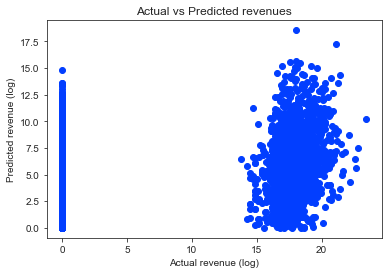

actuals: min = 0.0, mean = 0.2943813702846033, max = 23.442593540690858
pedictions: min = 0.0, mean = 0.21960571419287475, max = 18.528215429104048


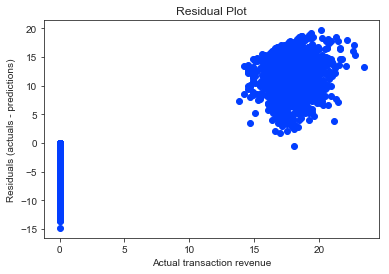

(1.7479258332375174,
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.0008934 , 0.00442506, 0.01089794, ..., 0.00085181, 0.0384335 ,
        0.00085181]))

In [608]:
evaluate_model(pred_val_2, y_test_2, X_test_2, train_df)

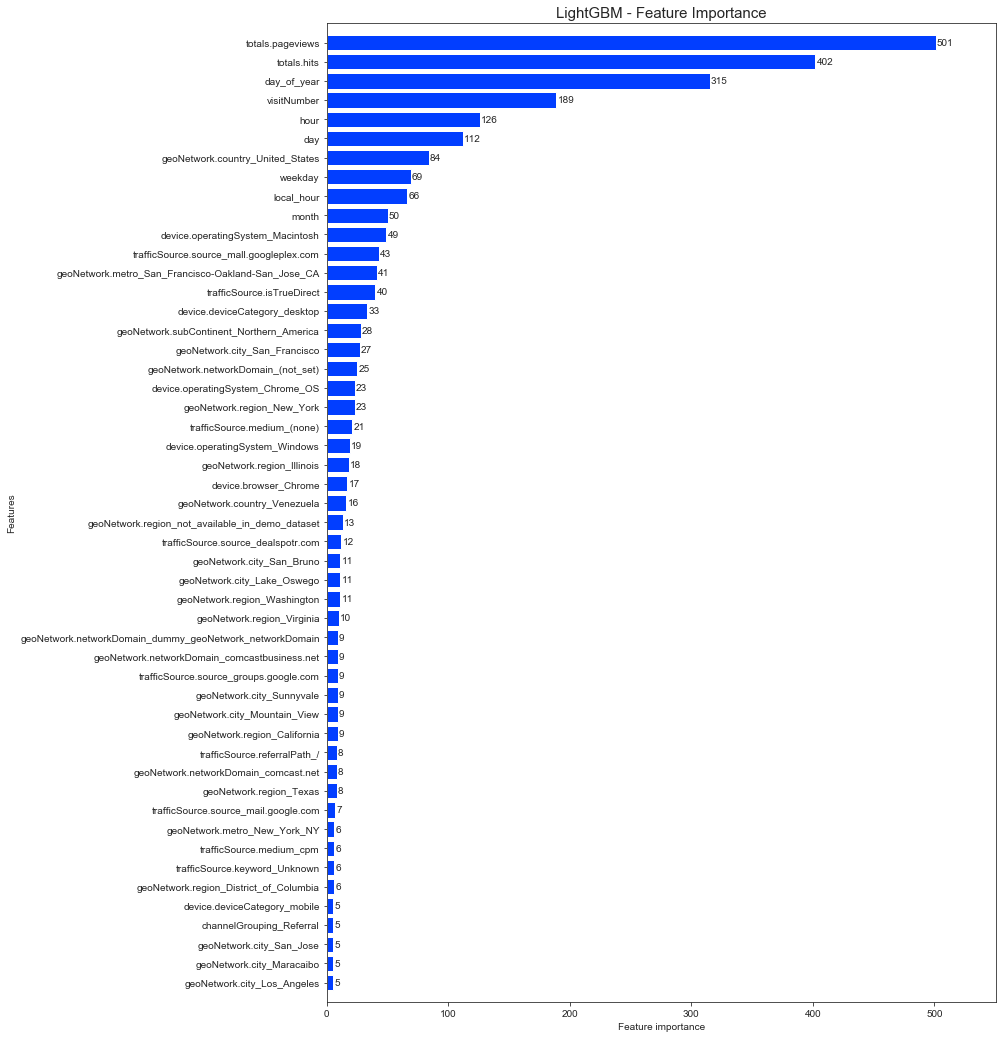

In [610]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(lgb_2, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

#### Let us create some more features

In [31]:
# the various category variables might have some important values
# starting with country lets generate new feature as rank based on mean revenue for that country

In [12]:
new_features = train_df[['geoNetwork.country','totals.transactionRevenue']].copy()

In [13]:
new_features.shape

(899888, 2)

In [14]:
countries_mean = pd.DataFrame(new_features.groupby('geoNetwork.country')['totals.transactionRevenue'].mean())

In [15]:
countries_mean['rank'] = countries_mean.rank().values

In [16]:
for ix in countries_mean.index:
    train_df.loc[train_df['geoNetwork.country']==ix,'country_rank'] = countries_mean.loc[ix,'rank']

In [17]:
new_features

,geoNetwork.country,totals.transactionRevenue,country_rank
0,Turkey,0.0,155.0
1,Australia,0.0,198.0
2,Spain,0.0,178.0
3,Indonesia,0.0,205.0
4,United Kingdom,0.0,181.0
...,...,...,...
903648,Puerto Rico,0.0,216.0
903649,Sri Lanka,0.0,77.5
903650,South Korea,0.0,201.0
903651,Indonesia,0.0,205.0


In [18]:
new_features = new_features['country_rank']

In [18]:
# Let us list category columns
cat_cols_3 = train_df.select_dtypes(include=[object]).columns

In [20]:
train_df.columns

Index(['channelGrouping', 'visitNumber', 'device.browser',
       'device.deviceCategory', 'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.campaignCode', 'trafficSource.isTrueDirect',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source', 'month', 'day',
       'weekday', 'hour', 'day_of_year', 'local_hour', 'country_rank'],
      dtype='object')

In [21]:
mod_cols = set(['geoNetwork.networkDomain','trafficSource.adwordsClickInfo.gclId','trafficSource.referralPath'])
cat_cols_mod = list(set(cat_cols_3) - mod_cols)

In [23]:
train_df.drop(['trafficSource.campaignCode'],axis=1,inplace=True)

In [24]:
train_df = pd.get_dummies(train_df, columns=(cat_cols_mod))

In [26]:
train_df.shape

(899888, 5561)

In [ ]:
train_date = pd.read_csv('../data/extra_cols_train.csv',usecols=['date'], index_col=0)

In [33]:
train_date

""
date
20160902
20160902
20160902
20160902
20160902
...
20170104
20170104
20170104


In [33]:
# adding this new feature to our dataset
trial_df_2 = pd.concat([trial_df, pd.DataFrame(new_features.values)], axis=1)

In [1]:
trial_df_2.shape

NameError: name 'trial_df_2' is not defined

In [36]:
train = train_date[train_date['date']<20170601].index
test = train_date[train_date['date']>=20170601].index

In [37]:
train

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            903643, 903644, 903645, 903646, 903647, 903648, 903649, 903650,
            903651, 903652],
           dtype='int64', length=762857)

In [ ]:
# it failed many times, why ??????
# X_train_2, X_test_2, y_train_2, y_test_2 = get_train_test(trial_df_2, pd.DataFrame(train_df['date']))

In [41]:
# remove others from memory for now
checkpoint_1_df = None

features_train_df = None


In [ ]:
# manually doing
X_train_2 = train_df[train_date<20170601]
#X_test_2 = trial_df_2[test]

In [38]:
trial_df_2.loc[train.values[0:10]]

KeyboardInterrupt: 

In [ ]:
X_train_2.shape, X_test_2.shape, y_train_2.shape, y_test_2.shape

#### Build model with one visitor per row

#### Error Analysis

In [204]:
X_new_train.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            903643, 903644, 903645, 903646, 903647, 903648, 903649, 903650,
            903651, 903652],
           dtype='int64', length=762857)

In [205]:
X_new_test.index

Int64Index([  4822,   4823,   4824,   4825,   4826,   4827,   4828,   4829,
              4830,   4831,
            ...
            901253, 901254, 901255, 901256, 901257, 901258, 901259, 901260,
            901261, 901262],
           dtype='int64', length=137031)

In [209]:
error_df = pd.DataFrame(data=pred_val_lgb_test, index=X_new_test.index, columns=['predicted'])

In [210]:
error_df['actuals'] = y_new_test

In [212]:
error_df['diff'] = error_df['actuals'] - error_df['predicted']

In [213]:
error_df.head()

,predicted,actuals,diff
4822,0.0032,0.0,-0.0032
4823,0.0032,0.0,-0.0032
4824,0.0032,0.0,-0.0032
4825,0.0032,0.0,-0.0032
4826,0.0032,0.0,-0.0032


In [220]:
error_df.describe()

,predicted,actuals,diff
count,137031.000000,137031.000000,137031.000000
mean,0.198715,0.259737,0.061022
std,1.035264,2.134832,1.719635
min,0.000000,0.000000,-17.709186
25%,0.003200,0.000000,-0.003200
50%,0.003200,0.000000,-0.003200
75%,0.003465,0.000000,-0.003200
max,17.709186,23.083095,20.391709


In [239]:
err_top = list(error_df.sort_values('diff',ascending=False).index[0:100])
err_top

[822787,
 275497,
 755145,
 172452,
 6584,
 338399,
 712338,
 150624,
 301970,
 275377,
 772077,
 816339,
 755154,
 808459,
 466908,
 587825,
 532690,
 196513,
 80049,
 202554,
 80397,
 679653,
 467250,
 755178,
 14293,
 531985,
 267030,
 455208,
 80489,
 502938,
 428645,
 698968,
 172511,
 196497,
 37984,
 428743,
 30832,
 266800,
 807546,
 594584,
 203801,
 467153,
 712530,
 850602,
 572866,
 626494,
 172389,
 773423,
 816173,
 712313,
 266790,
 712444,
 786347,
 772209,
 202701,
 14202,
 679207,
 532684,
 886454,
 41020,
 532600,
 267009,
 753074,
 773715,
 522881,
 726126,
 150594,
 886554,
 712446,
 679629,
 451091,
 37382,
 373131,
 551529,
 734168,
 286936,
 450962,
 150484,
 63018,
 14188,
 14246,
 755146,
 202085,
 375885,
 375899,
 13684,
 80192,
 196551,
 172409,
 711903,
 348131,
 808494,
 786418,
 339552,
 772367,
 197453,
 816478,
 287200,
 886512,
 816468]

In [ ]:
# how does the max error data look like?

In [248]:
X_new_test.loc[err_top].mean()

visitNumber                                 0.024352
trafficSource.adwordsClickInfo.isVideoAd    0.930000
active_hours                                0.910000
trafficSource.adwordsClickInfo.page         0.005000
totals.pageviews                            0.040682
                                              ...   
quarter_quarter2                            0.590000
quarter_quarter3                            0.390000
month_period_end                            0.670000
month_period_mid                            0.190000
month_period_start                          0.140000
Length: 148, dtype: float64

In [244]:
well_predicted_top = list(error_df.sort_values('diff',ascending=False).index[-100:])

In [249]:
X_new_test.loc[well_predicted_top].mean()

visitNumber                                 0.009715
trafficSource.adwordsClickInfo.isVideoAd    0.990000
active_hours                                1.000000
trafficSource.adwordsClickInfo.page         0.000714
totals.pageviews                            0.072708
                                              ...   
quarter_quarter2                            0.420000
quarter_quarter3                            0.560000
month_period_end                            0.600000
month_period_mid                            0.300000
month_period_start                          0.100000
Length: 148, dtype: float64

In [254]:
compare = pd.DataFrame(X_new_test.loc[err_top].mean(), columns=['errored'])

In [255]:
compare['good'] = X_new_test.loc[well_predicted_top].mean()

In [263]:
pd.set_option('display.max_rows', 500)
print(compare)
pd.set_option('display.max_rows', 50)

                                                     errored      good
visitNumber                                         0.024352  0.009715
trafficSource.adwordsClickInfo.isVideoAd            0.930000  0.990000
active_hours                                        0.910000  1.000000
trafficSource.adwordsClickInfo.page                 0.005000  0.000714
totals.pageviews                                    0.040682  0.072708
totals.newVisits                                    0.450000  0.170000
totals.hits                                         0.050080  0.083707
trafficSource.isTrueDirect                          0.550000  0.810000
week_day_end                                        0.870000  0.830000
totals.bounces                                      0.000000  0.000000
holidays                                            0.000000  0.000000
channelGrouping_Affiliates                          0.000000  0.000000
channelGrouping_Direct                              0.180000  0.130000
channe

In [ ]:
# now trying with simple label encoding

In [10]:
condition1 = ((train_df['visitNumber'] < 30) | (train_df['visitNumber'] > 280))
condition2 = (train_df['channelGrouping'] == 'Display')
condition3 = (~train_df['month'].isin([10,11]))
condition4 = (~train_df['weekday'].isin([6,7]))
condition5 = (train_df['day_of_year'] > 330)
condition6 = (~train_df['local_hour'].isin([7,8,9,10,11,12]))
condition7 = (train_df['device.operatingSystem'].isin(['Chrome OS','Linux']))
condition8 = (train_df['totals.hits']>20) & (train_df['totals.hits']<30)

In [ ]:
# let us bin for hits and derive new feature
hits_level 

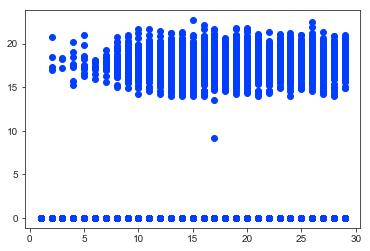

In [19]:
sample = train_df[(train_df['totals.hits']<30)]
plt.scatter(sample['totals.hits'], np.log1p(sample['totals.transactionRevenue']))

In [72]:
sample = train_df[train_df['totals.transactionRevenue']>0].sample(n=5000)
sample['holidays'] = 0
sample.loc[(sample['day_of_year'] > 330),'holidays'] = 1
sample['log_rev'] = np.log1p(sample['totals.transactionRevenue'])

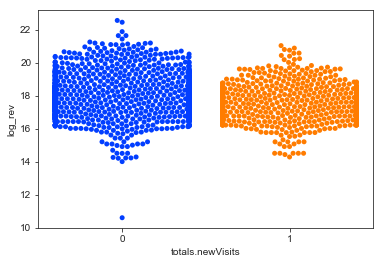

In [47]:
sns.swarmplot(data=sample, x='totals.newVisits', y='log_rev')

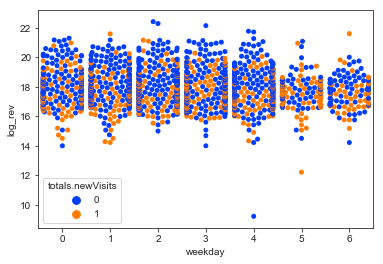

In [62]:
sns.swarmplot(data=sample, x='weekday', y='log_rev',hue='totals.newVisits')

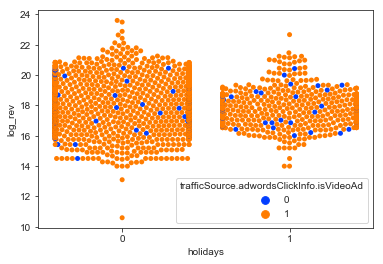

In [75]:
sns.swarmplot(data=sample, x='holidays', y='log_rev',hue='trafficSource.adwordsClickInfo.isVideoAd')

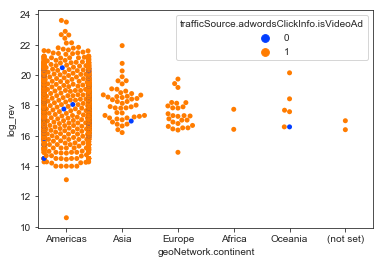

In [77]:
sns.swarmplot(data=sample, x='geoNetwork.continent', y='log_rev',hue='trafficSource.adwordsClickInfo.isVideoAd')

In [108]:
# should do something about the month, day etc. those can be binned and then one hot encoded
# for month we can divided in 4 quarters
# day of month can be divided in start,mid,end
# weekday can be divided as weekday and weekend
# day of the year can be ignore for now
# hour can be ignore for now



In [128]:
# drop other date columns
# features_train_df.drop(['month','day','weekday','hour','day_of_year'], axis=1, inplace=True)
# features_train_df.drop(['weekday','day_of_year','hour','month','day','local_hour'], axis=1, inplace=True)

In [129]:
features_train_df.shape

(899888, 34)

In [130]:
checkpoint_3_df = features_train_df.copy()

In [131]:
# one hot encode the categorical variables
# limit to categorical data using df.select_dtypes()
X_cat = features_train_df.select_dtypes(include=[object])
X_cat.columns

Index(['channelGrouping', 'device.browser', 'device.deviceCategory',
       'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source', 'month_period',
       'quarter', 'week_day_end'],
      dtype='object')

In [132]:
X_cat.shape

(899888, 22)

In [133]:
features_train_df.select_dtypes(exclude=[object]).columns

Index(['visitNumber', 'totals.bounces', 'totals.hits', 'totals.newVisits',
       'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page', 'trafficSource.campaignCode',
       'trafficSource.isTrueDirect', 'holidays', 'active_hours'],
      dtype='object')

In [134]:
[col  for col in features_train_df.select_dtypes(exclude=[object]).columns if features_train_df[col].nunique()>2]

['visitNumber',
 'totals.hits',
 'totals.pageviews',
 'totals.transactionRevenue',
 'trafficSource.adwordsClickInfo.page']

In [135]:
category_columns = list(X_cat.columns)
#category_columns.extend(['month','day','hour'])
category_columns

['channelGrouping',
 'device.browser',
 'device.deviceCategory',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.campaign',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source',
 'month_period',
 'quarter',
 'week_day_end']

In [136]:
X = pd.get_dummies(features_train_df, columns=category_columns)

In [137]:
X.shape

(899888, 151)

In [138]:
X.head()

,visitNumber,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.campaignCode,trafficSource.isTrueDirect,holidays,active_hours,channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,channelGrouping_dummy_channelGrouping,device.browser_Chrome,device.browser_Edge,device.browser_Firefox,device.browser_Internet Explorer,device.browser_Safari,device.browser_dummy_device_browser,device.deviceCategory_desktop,device.deviceCategory_mobile,device.deviceCategory_tablet,device.operatingSystem_Android,device.operatingSystem_Chrome OS,device.operatingSystem_Linux,device.operatingSystem_Macintosh,device.operatingSystem_Windows,device.operatingSystem_dummy_device_operatingSystem,device.operatingSystem_iOS,geoNetwork.city_(not set),geoNetwork.city_London,geoNetwork.city_Mountain View,geoNetwork.city_New York,geoNetwork.city_San Francisco,geoNetwork.city_San Jose,geoNetwork.city_Sunnyvale,geoNetwork.city_dummy_geoNetwork_city,geoNetwork.city_not available in demo dataset,geoNetwork.country_Australia,geoNetwork.country_Brazil,geoNetwork.country_Canada,geoNetwork.country_France,geoNetwork.country_Germany,geoNetwork.country_India,geoNetwork.country_Indonesia,geoNetwork.country_Italy,geoNetwork.country_Japan,geoNetwork.country_Mexico,geoNetwork.country_Netherlands,geoNetwork.country_Philippines,geoNetwork.country_Poland,geoNetwork.country_Russia,geoNetwork.country_Spain,geoNetwork.country_Taiwan,geoNetwork.country_Thailand,geoNetwork.country_Turkey,geoNetwork.country_United Kingdom,geoNetwork.country_United States,geoNetwork.country_Vietnam,geoNetwork.country_dummy_geoNetwork_country,geoNetwork.metro_(not set),geoNetwork.metro_London,geoNetwork.metro_Los Angeles CA,geoNetwork.metro_New York NY,geoNetwork.metro_San Francisco-Oakland-San Jose CA,geoNetwork.metro_dummy_geoNetwork_metro,geoNetwork.metro_not available in demo dataset,geoNetwork.networkDomain_(not set),geoNetwork.networkDomain_comcast.net,geoNetwork.networkDomain_comcastbusiness.net,geoNetwork.networkDomain_dummy_geoNetwork_networkDomain,geoNetwork.networkDomain_rr.com,geoNetwork.networkDomain_ttnet.com.tr,geoNetwork.networkDomain_unknown.unknown,geoNetwork.networkDomain_verizon.net,geoNetwork.region_(not set),geoNetwork.region_California,geoNetwork.region_England,geoNetwork.region_New York,geoNetwork.region_dummy_geoNetwork_region,geoNetwork.region_not available in demo dataset,geoNetwork.subContinent_Australasia,geoNetwork.subContinent_Central America,geoNetwork.subContinent_Eastern Asia,geoNetwork.subContinent_Eastern Europe,geoNetwork.subContinent_Northern America,geoNetwork.subContinent_Northern Europe,geoNetwork.subContinent_South America,geoNetwork.subContinent_Southeast Asia,geoNetwork.subContinent_Southern Asia,geoNetwork.subContinent_Southern Europe,geoNetwork.subContinent_Western Asia,geoNetwork.subContinent_Western Europe,geoNetwork.subContinent_dummy_geoNetwork_subContinent,trafficSource.adContent_Others,trafficSource.adContent_dummy_trafficSource_adContent,trafficSource.adwordsClickInfo.adNetworkType_Google Search,trafficSource.adwordsClickInfo.adNetworkType_Unknown,trafficSource.adwordsClickInfo.adNetworkType_dummy_trafficSource_adwordsClickInfo_adNetworkType,trafficSource.adwordsClickInfo.gclId_Unknown,trafficSource.adwordsClickInfo.gclId_dummy_trafficSource_adwordsClickInfo_gclId,trafficSource.adwordsClickInfo.slot_Top,trafficSource.adwordsClickInfo.slot_Unknown,trafficSource.adwordsClickInfo.slot_dummy_trafficSource_adwordsClickInfo_slot,trafficSource.campaign_(not set),trafficSource.campaign_AW - Dynamic Search Ads Whole Site,trafficSource.campaign_Data Share Promo,trafficSource.campaign_dummy_trafficSource_campaign,trafficSource.keyword_(not provided),trafficSource.keyword_6qEhsCssdK0z36ri,trafficSource.keyword_Unknown,trafficSource.keyword_du

In [33]:
# get train and test indices according to the dates
# last two months is test data

In [139]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,revenue,year,month,day,weekday,hour,day_of_year,local_hour
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,2,4,15,245,1
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,3,5,5,246,5
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,3,5,1,246,10
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,google + online,organic,Unknown,google,0.0,2016,9,3,5,5,246,5
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1,1,0,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,(not provided),organic,Unknown,google,0.0,2016,9,2,4,13,245,13


In [140]:
train_df['date'].min(), train_df['date'].max()

(20160801, 20170801)

In [141]:
#train = train_df[(train_df['date']<20170601) & (train_df.index.isin(X_2.index))].index
train = train_df[train_df['date']<20170601].index

In [142]:
len(train)

762857

In [143]:
#test = train_df[(train_df['date']>=20170601) & (train_df.index.isin(X_2.index)) ].index
test = train_df[train_df['date']>=20170601].index

In [144]:
len(test)

137031

In [145]:
X_train = X.loc[train]

In [146]:
X_test = X.loc[test]

In [147]:
y_train = X_train['totals.transactionRevenue']
y_test = X_test['totals.transactionRevenue']

In [148]:
train_df.shape

(899888, 44)

In [149]:
y_train = np.log1p(y_train.values)
y_test = np.log1p(y_test.values)

# or

# y_train = y_train/10**6
# y_test = y_test/10**6


In [150]:
y_train.shape, y_test.shape

((762857,), (137031,))

In [151]:
X_train.drop('totals.transactionRevenue', axis=1, inplace=True)
X_test.drop('totals.transactionRevenue', axis=1, inplace=True)

In [152]:
X_train.shape, X_test.shape

((762857, 150), (137031, 150))

In [132]:
# X_train.describe()

In [133]:
# save it temporarily
# X_train.to_csv("../data/X_train.csv")

In [134]:
# X_test.to_csv("../data/X_test.csv")
# y_train.to_csv("../data/y_train.csv")
# y_test.to_csv("../data/y_test.csv")

In [135]:
# Start with Linear Regression

In [153]:
reg = LinearRegression(normalize=True)

In [154]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [155]:
reg.score(X_test,y_test)

0.19728527872175194

In [245]:
#svr = SVR()

In [246]:
#svr.fit(X_train,y_train)

In [156]:
#import lightgbm as lgb

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



In [157]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((762857, 150), (762857,), (137031, 150), (137031,))

In [138]:
# model=LGBMRegressor(boosting_type='gbdt',num_leaves=31,max_depth=-1,learning_rate=0.01,n_estimators=1000,max_bin=255,subsample_for_bin=50000,
#               objective=None,min_split_gain=0,min_child_weight=3,min_child_samples=10,subsample=1,subsample_freq=1,colsample_bytree=1,
#               reg_alpha=0.1,reg_lambda=0,seed=17,silent=False,nthread=-1,n_jobs=-1)

In [158]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    #pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    #return pred_test_y, model, pred_val_y
    return model, pred_val_y

In [159]:
# Training the model #
model, pred_val = run_lgb(X_train, y_train, X_test, y_test)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.72304
[200]	valid_0's rmse: 1.72017
[300]	valid_0's rmse: 1.72098
Early stopping, best iteration is:
[242]	valid_0's rmse: 1.71958


In [160]:
X_train.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            903643, 903644, 903645, 903646, 903647, 903648, 903649, 903650,
            903651, 903652],
           dtype='int64', length=762857)

In [161]:
features_train_df.columns

Index(['channelGrouping', 'visitNumber', 'device.browser',
       'device.deviceCategory', 'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.campaignCode', 'trafficSource.isTrueDirect',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source', 'month_period',
       'quarter', 'week_day_end', 'holidays', 'active_hours'],
      dtype='object')

In [162]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.campaignCode', 'trafficSource.isTrueDirect',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source', 'revenue',

In [163]:
results_df = train_df[['fullVisitorId','totals.transactionRevenue']]

In [164]:
results_df.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            903643, 903644, 903645, 903646, 903647, 903648, 903649, 903650,
            903651, 903652],
           dtype='int64', length=899888)

In [165]:
results_df = results_df.loc[X_test.index]

In [166]:
results_df.shape

(137031, 2)

In [167]:
pred_val[pred_val<0] = 0

In [168]:
results_df['predicted_revenue'] = [np.expm1(rev) for rev in pred_val]

#or

#results_df['predicted_revenue'] = pred_val

# or

# results_df['predicted_revenue'] = pred_val*10**6

In [169]:
results_df.head()

,fullVisitorId,totals.transactionRevenue,predicted_revenue
4822,6136444193474843946,0.0,0.004221
4823,9499266297099251015,0.0,0.000000
4824,965275377736384905,0.0,0.000000
4825,4609130972135924274,0.0,0.001217
4826,7154533339220730030,0.0,0.000000


In [170]:
results_df = results_df.groupby("fullVisitorId")["totals.transactionRevenue", "predicted_revenue"].sum().reset_index()

In [171]:
results_df[results_df['totals.transactionRevenue'] > 0].sort_values(['totals.transactionRevenue'],ascending=False)

,fullVisitorId,totals.transactionRevenue,predicted_revenue
98837,9417857471295131045,1.517012e+10,4049.837892
2533,79204932396995037,7.047150e+09,100.910941
29550,1957458976293878100,6.709380e+09,460.797504
95099,9026840718082010040,6.423130e+09,612.254005
54229,4604965471651937146,4.280700e+09,139.936808
...,...,...,...
80614,7447137895250670218,1.500000e+06,111.182903
59797,5201418842615044194,1.500000e+06,1.234426
110612,9213584705844626996,1.200000e+06,1089.930763
96898,9213584705844626996,1.200000e+06,424.529476


In [172]:
print(np.sqrt(metrics.mean_squared_error(np.log1p(\
        results_df["totals.transactionRevenue"].values), np.log1p(results_df["predicted_revenue"].values))))

1.7599333828996941


In [173]:
# optional
print(np.sqrt(metrics.mean_squared_error(\
        results_df["totals.transactionRevenue"].values, results_df["predicted_revenue"].values)))

68752303.29137921


In [174]:
# test out if we predict 0 revenue ....just for testing purposes
results_df["zero_predicted"] = 0

In [175]:
print(np.sqrt(metrics.mean_squared_error(np.log1p(\
        results_df["totals.transactionRevenue"].values), np.log1p(results_df["zero_predicted"].values))))

2.2866025325494768


In [176]:
diff = np.sort(np.absolute(results_df['totals.transactionRevenue']-results_df['predicted_revenue']))

In [177]:
diff = [item for item in diff if item >10000]

In [178]:
diff[0:100]

[10066.08144138797,
 10097.438832139711,
 10225.824101111477,
 10489.541326465545,
 10530.082037000106,
 10868.178724438863,
 11008.110422790112,
 11547.507635446778,
 11792.715696757174,
 12273.308637003976,
 12378.888337899185,
 12381.925729913348,
 12569.647898856623,
 12717.20100502959,
 13075.2544375507,
 13115.43504487824,
 13193.191454044387,
 13220.6790625092,
 13591.048289803333,
 13792.435146584781,
 14204.635153842548,
 14238.885795339183,
 14521.553570777067,
 15197.71209503021,
 15392.507988860956,
 16363.748852096309,
 16528.795365990278,
 16530.29521111962,
 16866.435748344677,
 17460.13635422599,
 17725.531875677392,
 18352.536198550268,
 18551.716563301565,
 19141.60461688111,
 19433.541336652725,
 20372.19208614311,
 20488.788290996257,
 20636.030728862115,
 22108.23817425743,
 22479.179206915964,
 23599.601955138885,
 24718.62170687437,
 24764.75769879783,
 25902.329749191285,
 27307.070680510762,
 27497.344600244578,
 28922.32001557304,
 30113.930999292326,
 30231.8

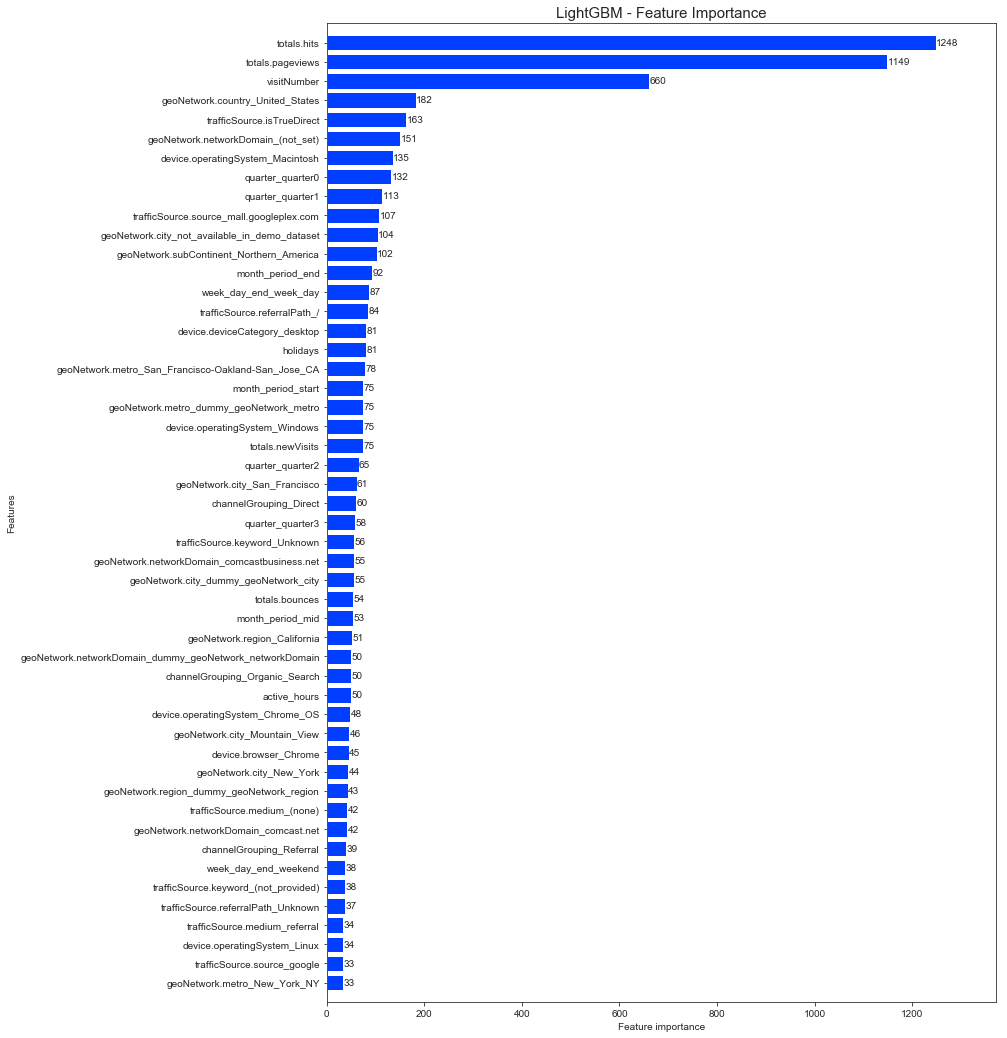

In [179]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

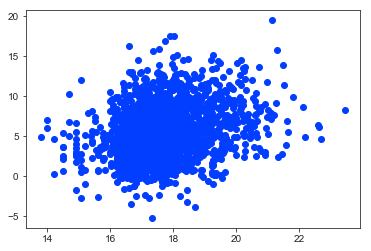

In [180]:
plt.scatter(results_df['totals.transactionRevenue'].apply(np.log), results_df['predicted_revenue'].apply(np.log))

In [181]:
np.log1p(results_df['totals.transactionRevenue']).describe()

count    111119.000000
mean          0.293390
std           2.267712
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          23.442594
Name: totals.transactionRevenue, dtype: float64

#### Testing on Future data

In [273]:
X_future = pd.read_csv('../data/X_future.csv', index_col=0, dtype={'fullVisitorId':np.str})

In [274]:
X_future['fullVisitorId'].nunique()

617242

In [275]:
X_future.head()

,fullVisitorId,visitNumber,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.isTrueDirect,channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,channelGrouping_dummy_channelGrouping,device.browser_Chrome,device.browser_Edge,device.browser_Firefox,device.browser_Internet Explorer,device.browser_Safari,device.browser_dummy_device_browser,device.deviceCategory_desktop,device.deviceCategory_mobile,device.deviceCategory_tablet,device.operatingSystem_Android,device.operatingSystem_Chrome OS,device.operatingSystem_Linux,device.operatingSystem_Macintosh,device.operatingSystem_Windows,device.operatingSystem_dummy_device_operatingSystem,device.operatingSystem_iOS,geoNetwork.city_(not set),geoNetwork.city_London,geoNetwork.city_Mountain View,geoNetwork.city_New York,geoNetwork.city_San Francisco,geoNetwork.city_San Jose,geoNetwork.city_Sunnyvale,geoNetwork.city_dummy_geoNetwork_city,geoNetwork.city_not available in demo dataset,geoNetwork.country_Australia,geoNetwork.country_Brazil,geoNetwork.country_Canada,geoNetwork.country_France,geoNetwork.country_Germany,geoNetwork.country_India,geoNetwork.country_Indonesia,geoNetwork.country_Italy,geoNetwork.country_Japan,geoNetwork.country_Mexico,geoNetwork.country_Netherlands,geoNetwork.country_Philippines,geoNetwork.country_Poland,geoNetwork.country_Russia,geoNetwork.country_Spain,geoNetwork.country_Taiwan,geoNetwork.country_Thailand,geoNetwork.country_Turkey,geoNetwork.country_United Kingdom,geoNetwork.country_United States,geoNetwork.country_Vietnam,geoNetwork.country_dummy_geoNetwork_country,geoNetwork.metro_(not set),geoNetwork.metro_London,geoNetwork.metro_Los Angeles CA,geoNetwork.metro_New York NY,geoNetwork.metro_San Francisco-Oakland-San Jose CA,geoNetwork.metro_dummy_geoNetwork_metro,geoNetwork.metro_not available in demo dataset,geoNetwork.networkDomain_(not set),geoNetwork.networkDomain_comcast.net,geoNetwork.networkDomain_comcastbusiness.net,geoNetwork.networkDomain_dummy_geoNetwork_networkDomain,geoNetwork.networkDomain_rr.com,geoNetwork.networkDomain_ttnet.com.tr,geoNetwork.networkDomain_unknown.unknown,geoNetwork.networkDomain_verizon.net,geoNetwork.region_(not set),geoNetwork.region_California,geoNetwork.region_England,geoNetwork.region_New York,geoNetwork.region_dummy_geoNetwork_region,geoNetwork.region_not available in demo dataset,geoNetwork.subContinent_Australasia,geoNetwork.subContinent_Central America,geoNetwork.subContinent_Eastern Asia,geoNetwork.subContinent_Eastern Europe,geoNetwork.subContinent_Northern America,geoNetwork.subContinent_Northern Europe,geoNetwork.subContinent_South America,geoNetwork.subContinent_Southeast Asia,geoNetwork.subContinent_Southern Asia,geoNetwork.subContinent_Southern Europe,geoNetwork.subContinent_Western Asia,geoNetwork.subContinent_Western Europe,geoNetwork.subContinent_dummy_geoNetwork_subContinent,trafficSource.adContent_Others,trafficSource.adContent_dummy_trafficSource_adContent,trafficSource.adwordsClickInfo.adNetworkType_Google Search,trafficSource.adwordsClickInfo.adNetworkType_Unknown,trafficSource.adwordsClickInfo.adNetworkType_dummy_trafficSource_adwordsClickInfo_adNetworkType,trafficSource.adwordsClickInfo.gclId_Unknown,trafficSource.adwordsClickInfo.gclId_dummy_trafficSource_adwordsClickInfo_gclId,trafficSource.adwordsClickInfo.slot_Top,trafficSource.adwordsClickInfo.slot_Unknown,trafficSource.adwordsClickInfo.slot_dummy_trafficSource_adwordsClickInfo_slot,trafficSource.campaign_(not set),trafficSource.campaign_AW - Dynamic Search Ads Whole Site,trafficSource.campaign_Data Share Promo,trafficSource.campaign_dummy_trafficSource_campaign,trafficSource.keyword_(not provided),trafficSource.keyword_6qEhsCssdK0z36ri,trafficSource.keyword_Unknown,trafficSource.keyword_dummy_trafficSource_keyword,trafficSource.medium_(none),traffic

In [276]:
checkpoint_4_df = X_future.copy()

In [277]:
X_future = checkpoint_4_df.copy()

In [278]:
X_future.shape, X_train.shape

((804684, 208), (762857, 212))

In [279]:
diff_cols = list(set(X_train.columns) - set(X_future.columns))

In [280]:
for col in diff_cols:
    X_future[col] = 0

In [281]:
model.predict(X_train)

array([ 0.00320659, -0.0031863 , -0.00268547, ...,  0.08219694,
        0.09142121,  0.98715848])

In [282]:
X_future_visitor = X_future['fullVisitorId']

In [283]:
X_future.drop(['fullVisitorId'], axis=1, inplace=True)

In [284]:
y_future = model.predict(X_future)

In [285]:
y_future

array([-0.13911628, -0.04694498, -0.08461778, ..., -1.61173956,
        0.86123551, -1.46171624])

In [286]:
y_future[y_future<0] = 0

In [287]:
X_future_visitor

0         6167871330617112363
1         0643697640977915618
2         6059383810968229466
3         2376720078563423631
4         2314544520795440038
                 ...         
804679    9084225574121020383
804680    6146210385566305056
804681    7484543584006767361
804682    2915966035609674201
804683    5334918847827785763
Name: fullVisitorId, Length: 804684, dtype: object

In [288]:
X_future_visitor.nunique()

617242

In [289]:
future_results_df = pd.DataFrame(X_future_visitor)

In [290]:
future_results_df['predicted_revenue'] = [np.expm1(rev) for rev in y_future]

In [291]:
future_results_df

,fullVisitorId,predicted_revenue
0,6167871330617112363,0.000000
1,0643697640977915618,0.000000
2,6059383810968229466,0.000000
3,2376720078563423631,0.000000
4,2314544520795440038,0.000036
...,...,...
804679,9084225574121020383,8.145243
804680,6146210385566305056,0.000000
804681,7484543584006767361,0.000000
804682,2915966035609674201,1.366082


In [251]:
#future_results_df['fullVisitorId'] = future_results_df['fullVisitorId'].astype(np.str)

In [257]:
#future_results_df['fullVisitorId'] = future_results_df['fullVisitorId'].apply(lambda x: x.zfill(19))

In [292]:
submission_df = future_results_df.groupby("fullVisitorId")["predicted_revenue"].sum().reset_index()

In [296]:
submission_df['predicted_revenue'] = np.log1p(submission_df['predicted_revenue'])

In [297]:
submission_df

,fullVisitorId,predicted_revenue
0,0000000259678714014,0.000000
1,0000049363351866189,0.066942
2,0000053049821714864,0.000000
3,0000059488412965267,0.225508
4,0000085840370633780,0.000000
...,...,...
617237,9999905960465191827,0.018584
617238,9999941518946450908,0.184867
617239,9999969142283897422,0.000000
617240,9999985820452794361,0.083363


In [298]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617242 entries, 0 to 617241
Data columns (total 2 columns):
fullVisitorId        617242 non-null object
predicted_revenue    617242 non-null float64
dtypes: float64(1), object(1)
memory usage: 9.4+ MB


In [261]:
#submission_df['fullVisitorId'] = submission_df['fullVisitorId'].astype(np.str)

In [262]:
#submission_df['fullVisitorId'] = submission_df['fullVisitorId'].apply(lambda x: x.zfill(19))

In [299]:
submission_df.to_csv('../data/submission.csv',header=['fullVisitorId','PredictedLogRevenue'],index=None)

In [229]:
numeric_cols = ['visitNumber', 'totals.hits', 'totals.pageviews', 'trafficSource.adwordsClickInfo.page']

In [230]:
# Normalize using Min-Max scaling
scaler = preprocessing.MinMaxScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [231]:
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.0003

model = Sequential()
model.add(Dense(256, kernel_initializer='glorot_normal', activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(128, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1))

adam = optimizers.adam(lr=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam)

In [232]:
print('Dataset size: %s' % X_train.shape[0])
print('Epochs: %s' % EPOCHS)
print('Learning rate: %s' % LEARNING_RATE)
print('Batch size: %s' % BATCH_SIZE)
print('Input dimension: %s' % X_train.shape[1])
print('Features used: %s' % X_train.columns.values)

Dataset size: 762857
Epochs: 10
Learning rate: 0.0003
Batch size: 64
Input dimension: 150
Features used: ['visitNumber' 'totals.bounces' 'totals.hits' 'totals.newVisits'
 'totals.pageviews' 'trafficSource.adwordsClickInfo.isVideoAd'
 'trafficSource.adwordsClickInfo.page' 'trafficSource.campaignCode'
 'trafficSource.isTrueDirect' 'holidays' 'active_hours'
 'channelGrouping_Affiliates' 'channelGrouping_Direct'
 'channelGrouping_Organic Search' 'channelGrouping_Paid Search'
 'channelGrouping_Referral' 'channelGrouping_Social'
 'channelGrouping_dummy_channelGrouping' 'device.browser_Chrome'
 'device.browser_Edge' 'device.browser_Firefox'
 'device.browser_Internet Explorer' 'device.browser_Safari'
 'device.browser_dummy_device_browser' 'device.deviceCategory_desktop'
 'device.deviceCategory_mobile' 'device.deviceCategory_tablet'
 'device.operatingSystem_Android' 'device.operatingSystem_Chrome OS'
 'device.operatingSystem_Linux' 'device.operatingSystem_Macintosh'
 'device.operatingSystem_Win

In [233]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               38656     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 71,681
Trainable params: 71,681
Non-trainable params: 0
_________________________________________________________________


In [234]:
%%time
history = model.fit(x=X_train.values, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(X_test.values, y_test))

Train on 762857 samples, validate on 137031 samples
Epoch 1/10
762857/762857 [==============================] - 27s 35us/step - loss: 3.1873 - val_loss: 3.2622
Epoch 2/10
762857/762857 [==============================] - 27s 35us/step - loss: 2.9032 - val_loss: 3.2641
Epoch 3/10
762857/762857 [==============================] - 27s 35us/step - loss: 2.8490 - val_loss: 3.1465
Epoch 4/10
762857/762857 [==============================] - 26s 35us/step - loss: 2.8214 - val_loss: 3.0962
Epoch 5/10
762857/762857 [==============================] - 26s 34us/step - loss: 2.8042 - val_loss: 3.1870
Epoch 6/10
762857/762857 [==============================] - 26s 35us/step - loss: 2.7846 - val_loss: 3.1782
Epoch 7/10
762857/762857 [==============================] - 27s 35us/step - loss: 2.7775 - val_loss: 3.1116
Epoch 8/10
762857/762857 [==============================] - 26s 35us/step - loss: 2.7583 - val_loss: 3.2851
Epoch 9/10
762857/762857 [==============================] - 27s 35us/step - loss: 2.

In [235]:
pred_val5 = model.predict(X_test)

In [236]:
pred_val5 = pred_val5.flatten()

In [237]:
pred_val5[pred_val5<0] = 0

In [238]:
mse5 = metrics.mean_squared_error(pred_val5, y_test)
rmse5 = np.sqrt(mse5)
mse5, rmse5

(3.1391632504418885, 1.771768396388729)

In [530]:
results_df['predicted_revenue'] = [np.expm1(rev) for rev in pred_val]

#or

#results_df['predicted_revenue'] = pred_val

# or

# results_df['predicted_revenue'] = pred_val*10**6

In [531]:
results_df.head()

,fullVisitorId,totals.transactionRevenue,predicted_revenue
4822,6136444193474843946,0.0,0.0
4823,9499266297099251015,0.0,0.0
4824,965275377736384905,0.0,0.0
4825,4609130972135924274,0.0,0.0
4826,7154533339220730030,0.0,0.0


In [532]:
results_df = results_df.groupby("fullVisitorId")["totals.transactionRevenue", "predicted_revenue"].sum().reset_index()

In [533]:
results_df[results_df['totals.transactionRevenue'] > 0].sort_values(['totals.transactionRevenue'],ascending=False)

,fullVisitorId,totals.transactionRevenue,predicted_revenue
98837,9417857471295131045,1.517012e+10,442083.855165
2533,79204932396995037,7.047150e+09,13.191463
29550,1957458976293878100,6.709380e+09,41.972765
95099,9026840718082010040,6.423130e+09,2059.452039
54229,4604965471651937146,4.280700e+09,108.371964
...,...,...,...
80614,7447137895250670218,1.500000e+06,560.232124
59797,5201418842615044194,1.500000e+06,0.000000
110612,9213584705844626996,1.200000e+06,11.325359
96898,9213584705844626996,1.200000e+06,4.015071


In [534]:
results_df

,fullVisitorId,totals.transactionRevenue,predicted_revenue
0,26722803385797,0.0,0.000000
1,48421062322244,0.0,0.000000
2,62267706107999,0.0,0.000000
3,62349695125717,0.0,0.000000
4,64767209884626,0.0,0.000000
...,...,...,...
111114,999156736475815013,0.0,0.000000
111115,9992851597599268755,0.0,0.000000
111116,9995936593177786964,0.0,0.028155
111117,9999773079368714197,0.0,0.000000


In [535]:
print(np.sqrt(metrics.mean_squared_error(np.log1p(\
        results_df["totals.transactionRevenue"].values), np.log1p(results_df["predicted_revenue"].values))))

1.8946303252666068


In [142]:
X_train.head()

,visitNumber,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.campaignCode,trafficSource.isTrueDirect,channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,channelGrouping_dummy_channelGrouping,device.browser_Chrome,device.browser_Edge,device.browser_Firefox,device.browser_Internet Explorer,device.browser_Safari,device.browser_dummy_device_browser,device.deviceCategory_desktop,device.deviceCategory_mobile,device.deviceCategory_tablet,device.operatingSystem_Android,device.operatingSystem_Chrome OS,device.operatingSystem_Linux,device.operatingSystem_Macintosh,device.operatingSystem_Windows,device.operatingSystem_dummy_device_operatingSystem,device.operatingSystem_iOS,geoNetwork.city_(not set),geoNetwork.city_London,geoNetwork.city_Mountain View,geoNetwork.city_New York,geoNetwork.city_San Francisco,geoNetwork.city_San Jose,geoNetwork.city_Sunnyvale,geoNetwork.city_dummy_geoNetwork_city,geoNetwork.city_not available in demo dataset,geoNetwork.country_Australia,geoNetwork.country_Brazil,geoNetwork.country_Canada,geoNetwork.country_France,geoNetwork.country_Germany,geoNetwork.country_India,geoNetwork.country_Indonesia,geoNetwork.country_Italy,geoNetwork.country_Japan,geoNetwork.country_Mexico,geoNetwork.country_Netherlands,geoNetwork.country_Philippines,geoNetwork.country_Poland,geoNetwork.country_Russia,geoNetwork.country_Spain,geoNetwork.country_Taiwan,geoNetwork.country_Thailand,geoNetwork.country_Turkey,geoNetwork.country_United Kingdom,geoNetwork.country_United States,geoNetwork.country_Vietnam,geoNetwork.country_dummy_geoNetwork_country,geoNetwork.metro_(not set),geoNetwork.metro_London,geoNetwork.metro_Los Angeles CA,geoNetwork.metro_New York NY,geoNetwork.metro_San Francisco-Oakland-San Jose CA,geoNetwork.metro_dummy_geoNetwork_metro,geoNetwork.metro_not available in demo dataset,geoNetwork.networkDomain_(not set),geoNetwork.networkDomain_comcast.net,geoNetwork.networkDomain_comcastbusiness.net,geoNetwork.networkDomain_dummy_geoNetwork_networkDomain,geoNetwork.networkDomain_rr.com,geoNetwork.networkDomain_ttnet.com.tr,geoNetwork.networkDomain_unknown.unknown,geoNetwork.networkDomain_verizon.net,geoNetwork.region_(not set),geoNetwork.region_California,geoNetwork.region_England,geoNetwork.region_New York,geoNetwork.region_dummy_geoNetwork_region,geoNetwork.region_not available in demo dataset,geoNetwork.subContinent_Australasia,geoNetwork.subContinent_Central America,geoNetwork.subContinent_Eastern Asia,geoNetwork.subContinent_Eastern Europe,geoNetwork.subContinent_Northern America,geoNetwork.subContinent_Northern Europe,geoNetwork.subContinent_South America,geoNetwork.subContinent_Southeast Asia,geoNetwork.subContinent_Southern Asia,geoNetwork.subContinent_Southern Europe,geoNetwork.subContinent_Western Asia,geoNetwork.subContinent_Western Europe,geoNetwork.subContinent_dummy_geoNetwork_subContinent,trafficSource.adContent_Others,trafficSource.adContent_dummy_trafficSource_adContent,trafficSource.adwordsClickInfo.adNetworkType_Google Search,trafficSource.adwordsClickInfo.adNetworkType_Unknown,trafficSource.adwordsClickInfo.adNetworkType_dummy_trafficSource_adwordsClickInfo_adNetworkType,trafficSource.adwordsClickInfo.gclId_Unknown,trafficSource.adwordsClickInfo.gclId_dummy_trafficSource_adwordsClickInfo_gclId,trafficSource.adwordsClickInfo.slot_Top,trafficSource.adwordsClickInfo.slot_Unknown,trafficSource.adwordsClickInfo.slot_dummy_trafficSource_adwordsClickInfo_slot,trafficSource.campaign_(not set),trafficSource.campaign_AW - Dynamic Search Ads Whole Site,trafficSource.campaign_Data Share Promo,trafficSource.campaign_dummy_trafficSource_campaign,trafficSource.keyword_(not provided),trafficSource.keyword_6qEhsCssdK0z36ri,trafficSource.keyword_Unknown,trafficSource.keyword_dummy_trafficSource_keyword,trafficSource.medium_(

In [91]:
X_train.describe()

,visitNumber,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.campaignCode,trafficSource.isTrueDirect,channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,channelGrouping_dummy_channelGrouping,device.browser_Chrome,device.browser_Edge,device.browser_Firefox,device.browser_Internet Explorer,device.browser_Safari,device.browser_dummy_device_browser,device.deviceCategory_desktop,device.deviceCategory_mobile,device.deviceCategory_tablet,device.operatingSystem_Android,device.operatingSystem_Chrome OS,device.operatingSystem_Linux,device.operatingSystem_Macintosh,device.operatingSystem_Windows,device.operatingSystem_dummy_device_operatingSystem,device.operatingSystem_iOS,geoNetwork.city_(not set),geoNetwork.city_London,geoNetwork.city_Mountain View,geoNetwork.city_New York,geoNetwork.city_San Francisco,geoNetwork.city_San Jose,geoNetwork.city_Sunnyvale,geoNetwork.city_dummy_geoNetwork_city,geoNetwork.city_not available in demo dataset,geoNetwork.country_Australia,geoNetwork.country_Brazil,geoNetwork.country_Canada,geoNetwork.country_France,geoNetwork.country_Germany,geoNetwork.country_India,geoNetwork.country_Indonesia,geoNetwork.country_Italy,geoNetwork.country_Japan,geoNetwork.country_Mexico,geoNetwork.country_Netherlands,geoNetwork.country_Philippines,geoNetwork.country_Poland,geoNetwork.country_Russia,geoNetwork.country_Spain,geoNetwork.country_Taiwan,geoNetwork.country_Thailand,geoNetwork.country_Turkey,geoNetwork.country_United Kingdom,geoNetwork.country_United States,geoNetwork.country_Vietnam,geoNetwork.country_dummy_geoNetwork_country,geoNetwork.metro_(not set),geoNetwork.metro_London,geoNetwork.metro_Los Angeles CA,geoNetwork.metro_New York NY,geoNetwork.metro_San Francisco-Oakland-San Jose CA,geoNetwork.metro_dummy_geoNetwork_metro,geoNetwork.metro_not available in demo dataset,geoNetwork.networkDomain_(not set),geoNetwork.networkDomain_comcast.net,geoNetwork.networkDomain_comcastbusiness.net,geoNetwork.networkDomain_dummy_geoNetwork_networkDomain,geoNetwork.networkDomain_rr.com,geoNetwork.networkDomain_ttnet.com.tr,geoNetwork.networkDomain_unknown.unknown,geoNetwork.networkDomain_verizon.net,geoNetwork.region_(not set),geoNetwork.region_California,geoNetwork.region_England,geoNetwork.region_New York,geoNetwork.region_dummy_geoNetwork_region,geoNetwork.region_not available in demo dataset,geoNetwork.subContinent_Australasia,geoNetwork.subContinent_Central America,geoNetwork.subContinent_Eastern Asia,geoNetwork.subContinent_Eastern Europe,geoNetwork.subContinent_Northern America,geoNetwork.subContinent_Northern Europe,geoNetwork.subContinent_South America,geoNetwork.subContinent_Southeast Asia,geoNetwork.subContinent_Southern Asia,geoNetwork.subContinent_Southern Europe,geoNetwork.subContinent_Western Asia,geoNetwork.subContinent_Western Europe,geoNetwork.subContinent_dummy_geoNetwork_subContinent,trafficSource.adContent_Others,trafficSource.adContent_dummy_trafficSource_adContent,trafficSource.adwordsClickInfo.adNetworkType_Google Search,trafficSource.adwordsClickInfo.adNetworkType_Unknown,trafficSource.adwordsClickInfo.adNetworkType_dummy_trafficSource_adwordsClickInfo_adNetworkType,trafficSource.adwordsClickInfo.gclId_Unknown,trafficSource.adwordsClickInfo.gclId_dummy_trafficSource_adwordsClickInfo_gclId,trafficSource.adwordsClickInfo.slot_Top,trafficSource.adwordsClickInfo.slot_Unknown,trafficSource.adwordsClickInfo.slot_dummy_trafficSource_adwordsClickInfo_slot,trafficSource.campaign_(not set),trafficSource.campaign_AW - Dynamic Search Ads Whole Site,trafficSource.campaign_Data Share Promo,trafficSource.campaign_dummy_trafficSource_campaign,trafficSource.keyword_(not provided),trafficSource.keyword_6qEhsCssdK0z36ri,trafficSource.keyword_Unknown,trafficSource.keyword_dummy_trafficSource_keyword,trafficSource.medium_(

In [102]:
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train) 

In [103]:
X_test_scaled = scaler.transform(X_test)

In [104]:
from sklearn.decomposition import PCA
pca = PCA()
principalComponents = pca.fit_transform(X_train_scaled)
# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2'])

In [105]:
principalComponents.shape

(762857, 212)

In [106]:
print(X_train.dtypes)

visitNumber         int64
totals.bounces      int64
totals.hits         int64
totals.newVisits    int64
totals.pageviews    int64
                    ...  
hour_19             uint8
hour_20             uint8
hour_21             uint8
hour_22             uint8
hour_23             uint8
Length: 212, dtype: object


In [107]:
pca.explained_variance_ratio_

array([1.29332501e-01, 8.82679297e-02, 7.11319776e-02, 5.05282585e-02,
       4.07115845e-02, 2.83156592e-02, 2.67646154e-02, 2.55868861e-02,
       2.45580468e-02, 2.30092870e-02, 2.24521057e-02, 2.12250451e-02,
       1.84917696e-02, 1.68005757e-02, 1.57700133e-02, 1.47585269e-02,
       1.32995154e-02, 1.11894422e-02, 1.06289313e-02, 8.98784717e-03,
       8.57852930e-03, 8.06585793e-03, 7.93361541e-03, 7.54910639e-03,
       7.44498533e-03, 7.25189473e-03, 7.01918658e-03, 6.93297595e-03,
       6.63267271e-03, 6.56782661e-03, 6.18169574e-03, 6.07790667e-03,
       5.92554510e-03, 5.46311610e-03, 5.05947004e-03, 4.62863679e-03,
       4.56311555e-03, 4.14769163e-03, 4.13353316e-03, 4.05983066e-03,
       4.03462779e-03, 3.93868669e-03, 3.88382865e-03, 3.83666886e-03,
       3.80529887e-03, 3.65361449e-03, 3.57365272e-03, 3.51765324e-03,
       3.38886846e-03, 3.32205620e-03, 3.28653886e-03, 3.19478611e-03,
       3.08769852e-03, 2.97157229e-03, 2.91990388e-03, 2.86967400e-03,
      

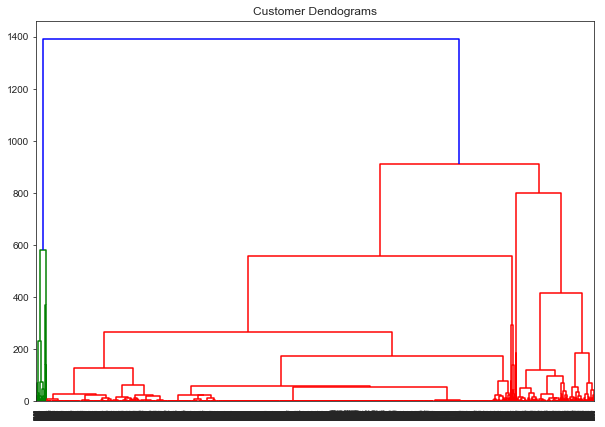

In [54]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Customer Dendograms")  
dend = shc.dendrogram(shc.linkage(principalComponents[0:10000,0:2], method='ward'))  

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(principalComponents[0:10000,0:25]) 

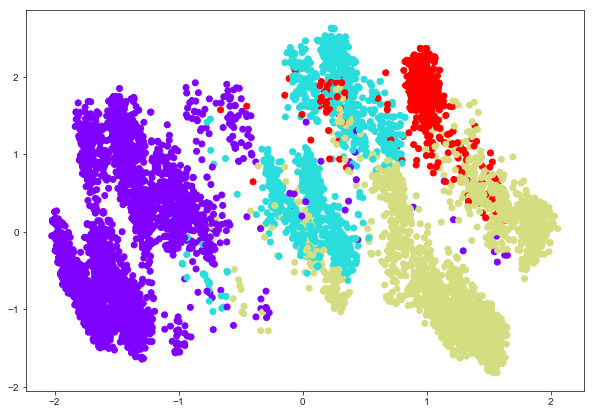

In [132]:
plt.figure(figsize=(10, 7))  
plt.scatter(principalComponents[0:10000,0], principalComponents[0:10000,1], c=cluster.labels_, cmap='rainbow')  

In [56]:
# Training the model #
#model, pred_val = run_lgb(X_train, y_train, X_test, y_test)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.71793
[200]	valid_0's rmse: 1.7128
[300]	valid_0's rmse: 1.71159
[400]	valid_0's rmse: 1.71418
Early stopping, best iteration is:
[300]	valid_0's rmse: 1.71159


In [123]:
pca_train = principalComponents[:,0:100]

In [124]:
pca_train.shape

(762857, 100)

In [125]:
pca_test = pca.transform(X_test_scaled)

In [126]:
pca_test = pca_test[:,0:100]

In [127]:
pca_test.shape

(137031, 100)

In [128]:
model, pred_val = run_lgb(pca_train, y_train, pca_test, y_test)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 2.05642
[200]	valid_0's rmse: 2.05671
Early stopping, best iteration is:
[114]	valid_0's rmse: 2.05606


In [ ]:
# linear regression for pca comp

In [1]:
reg = LinearRegression()

NameError: name 'LinearRegression' is not defined

In [87]:
reg.fit(pca_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [88]:
reg.score(pca_test, y_test)

0.19429417101008573

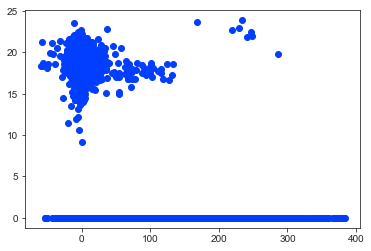

In [90]:
plt.scatter(pca_train[:,1],y_train)

### XGB model

In [182]:
#import xgboost as xgb


In [ ]:
xgb.train()

In [216]:
# custom function to run light gbm model
def run_xgb(train_X, train_y, val_X, val_y):
    params = {
        "objective" : "reg:linear",
        "metric" : "rmse",
        "max_depth": 5,
        "alpha": 10,
        "colsample_bytree": 0.3,
        "learning_rate" : 0.1,
        "verbosity" : -1,
        "n_estimators" : 100
    }
    
#     xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 10)
#     params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
#                 'max_depth': 5, 'alpha': 10}

#     cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
#                     num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

    lgtrain = xgb.DMatrix(data=train_X, label=train_y)
    lgval = xgb.DMatrix(data=val_X, label=val_y)
    model = xgb.train(params, lgtrain, num_boost_round=1000, early_stopping_rounds=100, verbose_eval=100)
    
    #pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    #return pred_test_y, model, pred_val_y
    return model, pred_val_y

In [217]:
# Training the model #
model2, pred_val2 = run_xgb(X_train, y_train, X_test, y_test)

[00:33:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5


IndexError: list index out of range

In [220]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.2, 'colsample_bytree': 0.2, 
             'objective': 'reg:linear', 'max_depth':3, 'min_child_weight':1} 
# Grid Search CV optimized settings
lgtrain = xgb.DMatrix(data=X_train[0:1000], label=y_train[0:1000])

cv_xgb = xgb.cv(params = our_params, dtrain = lgtrain, num_boost_round = 1000, nfold = 5,
                metrics = ['rmse'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

[00:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[00:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[00:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[00:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[00:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[00:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[00:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[00:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth

[00:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[00:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[00:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[00:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[00:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[00:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[00:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[00:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[00:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_d

[00:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[00:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[00:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[00:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[00:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[00:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[00:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[00:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[00:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_d

In [221]:
xgb1 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [226]:
xgb1.fit(X_train[0:10000],y_train[0:10000],eval_metric='rmse')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [227]:
pred_val4 = xgb1.predict(X_test)

In [228]:
pred_val4[pred_val4<0]=0
mse4 = metrics.mean_squared_error(pred_val4, y_test)
rmse4 = np.sqrt(mse4)
mse4, rmse4

(3.8004581123174166, 1.9494763687507004)

In [198]:
rf = RandomForestRegressor(n_estimators=1000)

In [212]:
rf.fit(X=X_train[0:10000],y=y_train[0:10000])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [213]:
pred_val2 = rf.predict(X=X_test)

In [214]:
pred_val2[pred_val2<0]=0

In [215]:
mse2 = metrics.mean_squared_error(pred_val2, y_test)
rmse2 = np.sqrt(mse2)
mse2, rmse2

(3.285277652381431, 1.8125334900027175)

In [202]:
rf.score(X_test,y_test)

0.18737383991252454

In [203]:
from sklearn.tree import DecisionTreeRegressor

In [207]:
dt = DecisionTreeRegressor()
dt.fit(X=X_train,y=y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [208]:
pred_val3 = dt.predict(X=X_test)

In [210]:
pred_val3[pred_val3<0]=0

In [211]:
mse3 = metrics.mean_squared_error(pred_val3, y_test)
rmse3 = np.sqrt(mse3)
mse3, rmse3

(5.451158911230031, 2.334771704306447)